### About this test:

#### The fundamental task is to use the information about the applicant in their credit report to predict whether they will repay their customers Credit within 2 years. The target variable to predict is a binary variable called RiskPerformance. The value “Bad” indicates that a consumer was 90 days past due or worse at least once over a period of 24 months from when the credit account was opened. The value “Good” indicates that they have made their payments without ever being more than 90 days overdue.

#### In the last assignment, we made the following improvements to the data：

- The data is categorized into categories and continuous features
- Delete the duplicate rows
- Special value -9  were dropped as part of the initial cleaning as they contained no usable information.
- Changed Special value -8 to null
- Replace Special value -7 appeared in 2 features MSinceMostRecentInqexcl7days & MSinceMostRecentDelq. It indicates condition not met.
- Remap scales used for similar features: Map MaxDelqE2PublicREcLast12M scale to match MaxDelqEver scale, Combine “unknown delinquency” & “current or never delinquent”
- Check the outliers
- Compare the correlations
- Compare the Continuous between Continuous, Categorical between Categorical, Continuous between Categorical
- Add a new feature "DelqEver" to Measures if a entry during their history has ever been delinquent
- Add a new feature "DelqLast12M" to Measures if a entry during the last 12 months has ever been delinquent
- Add a new feature "PercentSatisfactoryTrades" to Measure the Percentage of satisfactory trades
- Add a new feature "NumTradesWBalance“  with balance = (percentage of trades with a balance * number total trades) / 100

### In this assignment I will do some prediction for the company to assess the risk. I will do the linear regression prediction model first, and do logistic, and then do random forest. After that, I will find out some method to try to improve my model. The prediction can help the customers' credit company to predict the risk performance of customers so as to help them select customers and reduce risks


#### Import the packages

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score 
# Allows plots to appear directly in the notebook.
%matplotlib inline

# 1. Reading and Cleaning Data

In [2]:
# read the data
df = pd.read_csv('CreditRisk-17210995_1-3_cleaned_new_features.csv',  keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [3]:
# check the data types
df.dtypes

RiskPerformance                        object
ExternalRiskEstimate                    int64
MSinceOldestTradeOpen                   int64
MSinceMostRecentTradeOpen               int64
AverageMInFile                          int64
NumSatisfactoryTrades                   int64
NumTrades60Ever2DerogPubRec             int64
NumTrades90Ever2DerogPubRec             int64
PercentTradesNeverDelq                  int64
MSinceMostRecentDelq                    int64
MaxDelq2PublicRecLast12M                int64
MaxDelqEver                             int64
NumTotalTrades                          int64
NumTradesOpeninLast12M                  int64
PercentInstallTrades                    int64
MSinceMostRecentInqexcl7days            int64
NumInqLast6M                            int64
NumInqLast6Mexcl7days                   int64
NetFractionRevolvingBurden              int64
NetFractionInstallBurden              float64
NumRevolvingTradesWBalance              int64
NumInstallTradesWBalance          

Based on examining the data in a spreadsheet program, 3 of the features are categorical and the rest continuous.

- *RiskPerformance* will be converted to **categorical** because it contains only 2 possible values, true or false.
- *'MaxDelq2PublicRecLast12M'* column will be converted to **categorical** because it contains a finite set of possible values, *(0-9)*, each representing a different meaning, thus a different category.
- *'MaxDelqEver'* column will be converted to **categorical** because it contains a finite set of possible values, *(1-9)*, each representing a different meaning.
- *DelqEver* will be converted to **categorical** because it contains only 2 possible values, true or false.
- *DelqLast12M* will be converted to **categorical** because it contains only 2 possible values, true or false.

In [4]:
#convert all the categorical features 
categorical_columns = df[['RiskPerformance','MaxDelq2PublicRecLast12M','MaxDelqEver','DelqEver','DelqLast12M']].columns
for column in categorical_columns:
    df[column] = df[column].astype('category')

In [5]:
#convert all the continuous features 
continuous_columns = []
for column in df.columns.values:
    if column not in categorical_columns:
        continuous_columns.append(column)
continuous_columns

['ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentTradeOpen',
 'AverageMInFile',
 'NumSatisfactoryTrades',
 'NumTrades60Ever2DerogPubRec',
 'NumTrades90Ever2DerogPubRec',
 'PercentTradesNeverDelq',
 'MSinceMostRecentDelq',
 'NumTotalTrades',
 'NumTradesOpeninLast12M',
 'PercentInstallTrades',
 'MSinceMostRecentInqexcl7days',
 'NumInqLast6M',
 'NumInqLast6Mexcl7days',
 'NetFractionRevolvingBurden',
 'NetFractionInstallBurden',
 'NumRevolvingTradesWBalance',
 'NumInstallTradesWBalance',
 'NumBank2NatlTradesWHighUtilization',
 'PercentTradesWBalance',
 'percent',
 'PercentSatisfactoryTrades',
 'NumTradesWBalance']

In [6]:
df.dtypes

RiskPerformance                       category
ExternalRiskEstimate                     int64
MSinceOldestTradeOpen                    int64
MSinceMostRecentTradeOpen                int64
AverageMInFile                           int64
NumSatisfactoryTrades                    int64
NumTrades60Ever2DerogPubRec              int64
NumTrades90Ever2DerogPubRec              int64
PercentTradesNeverDelq                   int64
MSinceMostRecentDelq                     int64
MaxDelq2PublicRecLast12M              category
MaxDelqEver                           category
NumTotalTrades                           int64
NumTradesOpeninLast12M                   int64
PercentInstallTrades                     int64
MSinceMostRecentInqexcl7days             int64
NumInqLast6M                             int64
NumInqLast6Mexcl7days                    int64
NetFractionRevolvingBurden               int64
NetFractionInstallBurden               float64
NumRevolvingTradesWBalance               int64
NumInstallTra

# (1). [25] Data Understanding and Prep: Exploring relationships between feature pairs and selecting/transforming promising features based on a training set.

###  (1.1) Randomly shuffle the rows of your dataset and split the dataset into two datasets: 70% training and 30% test. Keep the test set aside. 

In [7]:
# check the data's number of columns and rows
df.shape

(827, 29)

In [8]:
df.dtypes

RiskPerformance                       category
ExternalRiskEstimate                     int64
MSinceOldestTradeOpen                    int64
MSinceMostRecentTradeOpen                int64
AverageMInFile                           int64
NumSatisfactoryTrades                    int64
NumTrades60Ever2DerogPubRec              int64
NumTrades90Ever2DerogPubRec              int64
PercentTradesNeverDelq                   int64
MSinceMostRecentDelq                     int64
MaxDelq2PublicRecLast12M              category
MaxDelqEver                           category
NumTotalTrades                           int64
NumTradesOpeninLast12M                   int64
PercentInstallTrades                     int64
MSinceMostRecentInqexcl7days             int64
NumInqLast6M                             int64
NumInqLast6Mexcl7days                    int64
NetFractionRevolvingBurden               int64
NetFractionInstallBurden               float64
NumRevolvingTradesWBalance               int64
NumInstallTra

#### I saved X as descriptive features to predict target feature, which is not included the target feature, y as target feature, which is the one that we need to predicted. And then I split the data into train and test sets, take a third (random) data samples as test data, rest as training data. The train data set is to train the prediction model , test is to check the model how good is with the new data. And then I concatenate X, y train data set and X,y test data set separately.

In [9]:
#Randomly shuffle rows in a dataset and split the dataset into two datasets: 70% training and 30% test. 
X = df[[X for X in df.columns.values if X not in['RiskPerformance']]]
y = df.RiskPerformance
print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

df_train = pd.concat([X_train, y_train], axis=1)
df_test =pd.concat([X_test, y_test], axis=1)


Descriptive features in X:
      ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
0                      78                    227                          5   
1                      77                    101                         13   
2                      81                    131                         16   
3                      73                    280                          8   
4                      68                    220                          9   
5                      62                    322                          1   
6                      73                    211                          5   
7                      84                    133                          1   
8                      65                    245                         28   
9                      68                     89                          9   
10                     79                    108                          4   
11                     

#### I saved all the train data and test data into csv, it is because every time we run the last cell, which is to split the data, it will shuffle the data and change all the data  again, it is not good for the following that doing the prediction part, so after I saved it, comment it out, so that we can use the same data, and the accuracy will not change

In [10]:
# df_train.to_csv("train.csv")
# df_test.to_csv("test.csv")
# X_train.to_csv("X_train.csv")
# X_test.to_csv("X_test.csv")
# y_train.to_csv("y_train.csv")
# y_train.to_csv("y_test.csv")

In [11]:
# read the data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

### (1.2) On the training set:
### Plot the correlations between all the continuous features.


In [12]:
# Get the correlation of continuous columns
df_train[continuous_columns].corr()

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,NumTotalTrades,...,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,percent,PercentSatisfactoryTrades,NumTradesWBalance
ExternalRiskEstimate,1.000000,0.185236,0.122041,0.244121,-0.010532,-0.451439,-0.357417,0.558875,0.652839,-0.071508,...,-0.172380,-0.649176,-0.064598,-0.380157,-0.145200,-0.452556,-0.502261,-0.551441,0.270467,-0.317298
MSinceOldestTradeOpen,0.185236,1.000000,0.072034,0.702011,0.291884,-0.052794,-0.077889,0.045085,-0.056149,0.306554,...,-0.111347,-0.135712,-0.084478,0.185130,-0.016549,0.061600,-0.227210,0.072020,0.016948,0.181112
MSinceMostRecentTradeOpen,0.122041,0.072034,1.000000,0.445587,-0.253043,0.076585,0.052643,-0.137218,-0.014633,-0.247709,...,-0.189909,-0.045106,-0.217496,-0.153974,-0.137348,-0.084112,0.010741,0.059069,-0.073874,-0.196894
AverageMInFile,0.244121,0.702011,0.445587,1.000000,0.120030,0.040413,0.005909,-0.062953,-0.059941,0.124106,...,-0.206538,-0.125136,-0.223194,0.083018,-0.127869,0.016359,-0.170468,0.103068,-0.010642,0.065599
NumSatisfactoryTrades,-0.010532,0.291884,-0.253043,0.120030,1.000000,-0.183363,-0.176128,0.316632,-0.001176,0.934844,...,0.123591,-0.076420,-0.043419,0.495631,0.361878,0.253355,-0.220314,0.018385,0.280450,0.724611
NumTrades60Ever2DerogPubRec,-0.451439,-0.052794,0.076585,0.040413,-0.183363,1.000000,0.894361,-0.675987,-0.456247,-0.066672,...,0.049218,0.160308,0.019626,-0.025083,-0.032221,-0.019690,0.179309,0.312246,-0.534758,0.029562
NumTrades90Ever2DerogPubRec,-0.357417,-0.077889,0.052643,0.005909,-0.176128,0.894361,1.000000,-0.539994,-0.338485,-0.065470,...,0.036999,0.125304,0.023534,-0.052621,-0.018192,-0.048655,0.173046,0.193862,-0.496089,0.026107
PercentTradesNeverDelq,0.558875,0.045085,-0.137218,-0.062953,0.316632,-0.675987,-0.539994,1.000000,0.648912,0.218562,...,0.012392,-0.201172,0.025624,0.050309,0.097524,-0.003723,-0.225083,-0.481035,0.554467,0.095626
MSinceMostRecentDelq,0.652839,-0.056149,-0.014633,-0.059941,-0.001176,-0.456247,-0.338485,0.648912,1.000000,-0.059606,...,0.001145,-0.220187,0.016668,-0.148822,-0.037804,-0.085595,-0.176132,-0.650853,0.282335,-0.144007
NumTotalTrades,-0.071508,0.306554,-0.247709,0.124106,0.934844,-0.066672,-0.065470,0.218562,-0.059606,1.000000,...,0.137960,-0.047969,-0.034996,0.461037,0.351445,0.237072,-0.186816,0.064326,-0.021087,0.804556


#### The correlation between the continuous columns:
- 1 means they have a perfect correlation, usually the features are the same with 1 correlation
- Negative values have a negative correlation. Generally, as one feature increases, another feature decreases
 - **NetFractionRevolvingBurden** and **ExternalRiskEstimate** have a high negative correlation, which is about 0.64, which means, with the external risk estimate higher, the net fraction revolving burden gets lower, it is reasonable,  your balance in relation to your credit increases,the less risky the applicant probably is.
 - **NumTrades60Ever2DerogPubRec** and **PercentTradesNeverDelq** have a high negative correlation, which is about 0.64, which means, with the Number of Trades 60+ Ever 2 Derogatory PubRec higher, the Percent Trades Never Delinquent get lower. The people never delinquent, they will not derogatory

- Positive values have a positive correlation. Generally, as one feature increases, another feature increase
 - **NumTotalTrades** and **NumSatisfactoryTrades** have a high positive correlation, which is about 0.95, which means, with the Number of Total Trades higher, Number of Satisfactory Trades higher, that makes sense because if the trade is not satisfied by the person, they will not have more trade on this company.
 - **NumInqLast6Mexcl7days** and **NumInqLast6M** have a high positive correlation, which is about 0.95, which means, with the NumInqLast6Mexcl7days higher, NumInqLast6M higher, these two features are similar, just exclude 7 days, they have the similar numbers, so they must be high correlation.
 - **NumTrades60Ever2DerogPubRec** and **NumTrades90Ever2DerogPubRec** have a high positive correlation, which is about 0.85, which means, with the NumTrades60Ever2DerogPubRec higher, NumTrades90Ever2DerogPubRec higher, these two features are similar, just have 30 days difference, they have the similar numbers, so they must be high correlation.
 - **NumTotalTrades** and **NumTradesWBalance**have a high positive correlation, which is about 0.85, which means, with the NumTotalTrades higher, NumTradesWBalance higher, Number of trades with balance = (percentage of trades with a balance * number total trades) / 100, that's why they have a high correlations


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]), <a list of 24 Text xticklabel objects>)

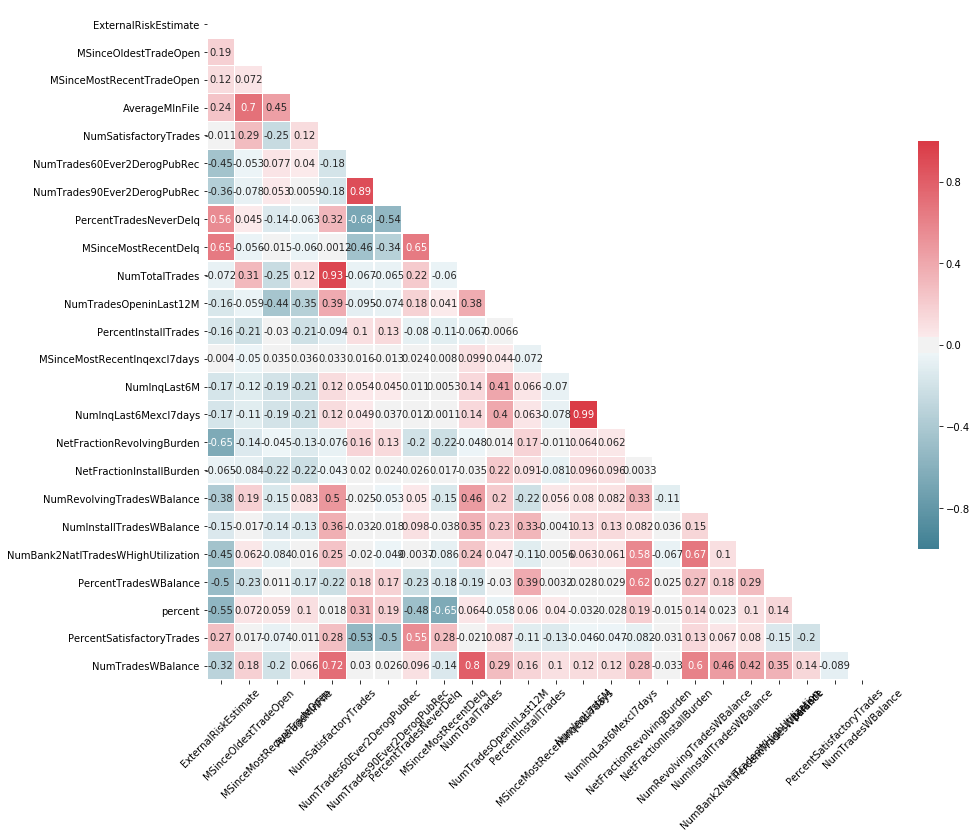

In [13]:
# Plot the correlations between all the continuous features
# Calculate correlation of all pairs of continuous features
corr = df_train[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)

#### I select the correlation coefficient >= 0.6 and  plot continuous features that have been shown to be highly correlated 

/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


ExternalRiskEstimate MSinceMostRecentDelq
MSinceOldestTradeOpen AverageMInFile
NumSatisfactoryTrades NumTotalTrades
NumSatisfactoryTrades NumTradesWBalance
NumTrades60Ever2DerogPubRec NumTrades90Ever2DerogPubRec
PercentTradesNeverDelq MSinceMostRecentDelq
NumTotalTrades NumTradesWBalance
NumInqLast6M NumInqLast6Mexcl7days
NetFractionRevolvingBurden PercentTradesWBalance
NumRevolvingTradesWBalance NumBank2NatlTradesWHighUtilization
NumRevolvingTradesWBalance NumTradesWBalance


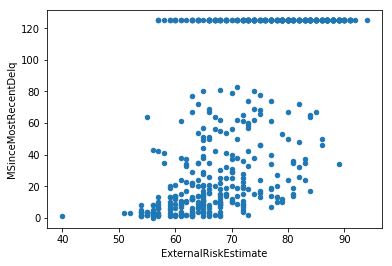

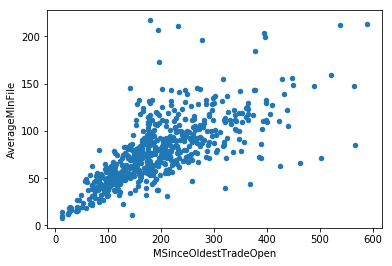

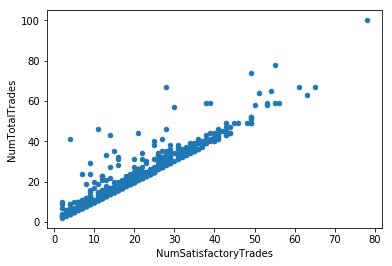

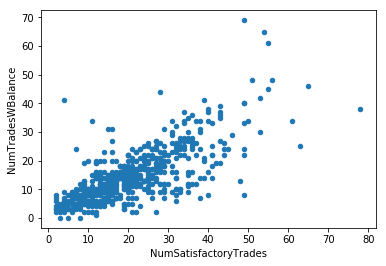

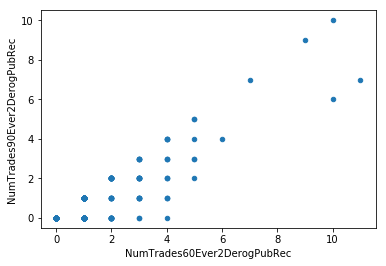

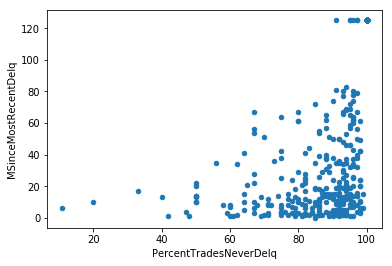

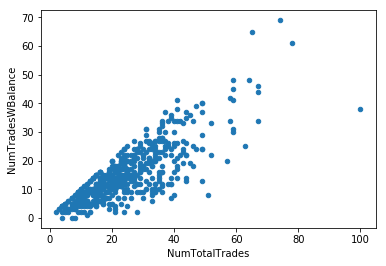

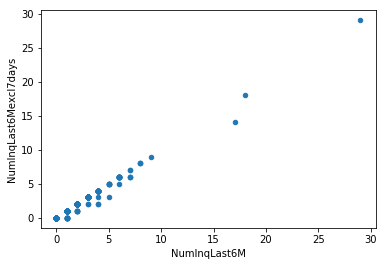

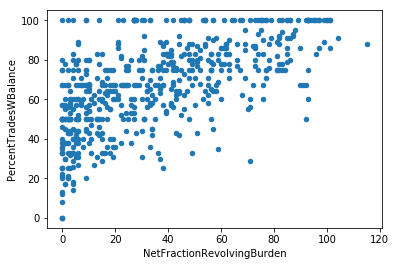

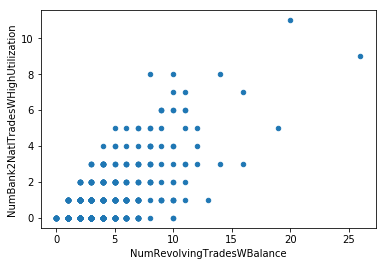

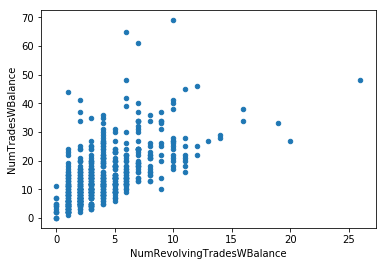

In [14]:
# Plot the correlations between all the continuous features.
push_continuous_columns = continuous_columns.copy()
for i in range(len(continuous_columns)):
    push_continuous_columns.pop(0)
    for j in push_continuous_columns:
        if(df_train[[continuous_columns[i], j]].corr().as_matrix()[0,1] > 0.6):
            print(continuous_columns[i], j)
            df_train.plot(kind='scatter', x=continuous_columns[i], y=j)  


# Discuss what you see in these plots.

Plots indicate that there are some feathers have a high correlation(The correlation coefficient>=0.5):
As can be seen from the diagram, the features with high correlation have a certain linear relationship.
- **ExternalRiskEstimate** and **MSinceMostRecentDelq** don't have an obvious linear correlation
- **MSinceOldestTradeOpen** and **AverageMInFile**have a obvious linear correlation, they have positive correlation the older month since oldest trade open. the more average month in the file.
- **NumSatisfactoryTrades** and **NumTotalTrades** have a line cut off, which may be a limit on the number of satisfied transactions, which must not exceed the total number of transactions
- NumSatisfactoryTrades NumTradesWBalance
- **NumTrades60Ever2DerogPubRec** and  **NumTrades90Ever2DerogPubRec** have a high positive correlation, these two features are similar, just have 30 days difference, they have similar numbers, so they must be high correlation. They are worth discussing but do not include some that are highly relevant but do not provide additional information
- **PercentTradesNeverDelq** and **MSinceMostRecentDelq** they have a positive correlation, which makes sense, because they are about delinquent
- **NumTotalTrades** and **NumTradesWBalance**ave a high positive correlation, which is about 0.85, which means, with the NumTotalTrades higher, NumTradesWBalance higher, Number of trades with balance = (percentage of trades with a balance * number total trades) / 100, that's why they have a high correlations
- **NumInqLast6M** and **NumInqLast6Mexcl7days**. They are worth discussing but do not include some that are highly relevant but do not provide additional information
- **NetFractionRevolvingBurden** and **PercentTradesWBalance**the net fraction revolving burden gets lower, it is reasonable, your balance in relation to your credit increases,the less risky the applicant probably is, the more trade with balance.
- **NumRevolvingTradesWBalance** and **NumBank2NatlTradesWHighUtilization**Number Revolving Trades with Balance is higher, the Number Bank/Natl Trades with high utilization ratio is higher
- **NumRevolvingTradesWBalance** and **NumTradesWBalance** Number of trades with balance = (percentage of trades with a balance * number total trades, the higher of a percentage of trades with a balance, and the lower of number total trades, the higher of Number Revolving Trades with Balance

### For each continuous feature, plot its interaction with the target feature (a plot for each pair of continuous feature and target feature). 

/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

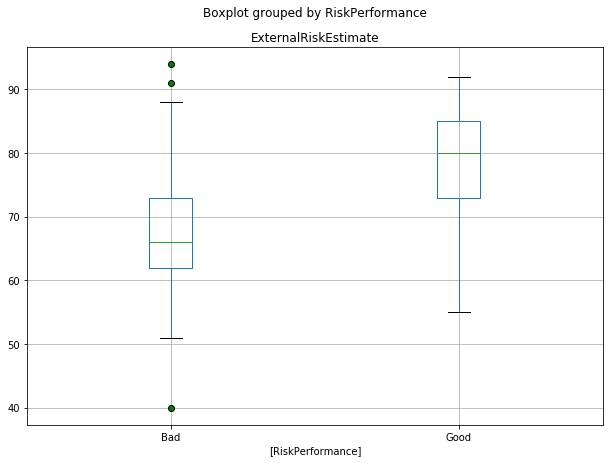

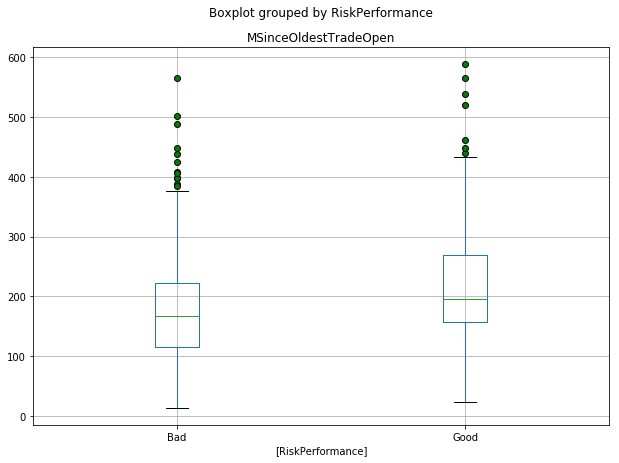

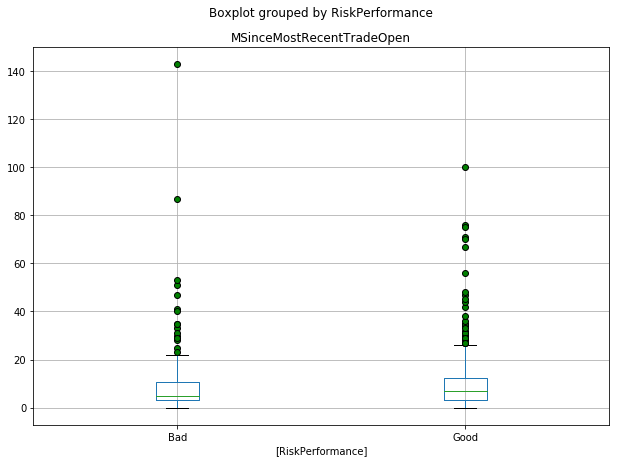

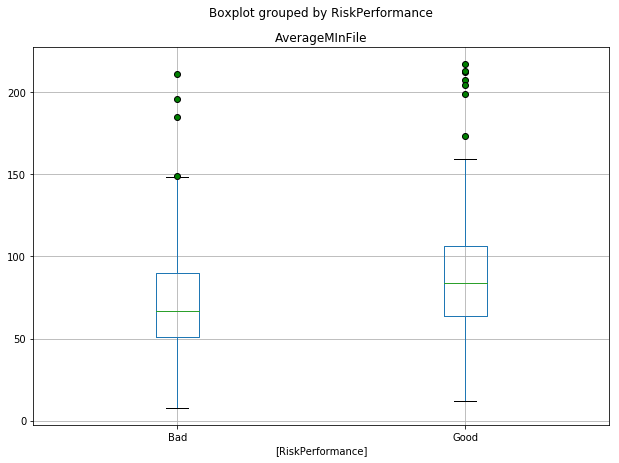

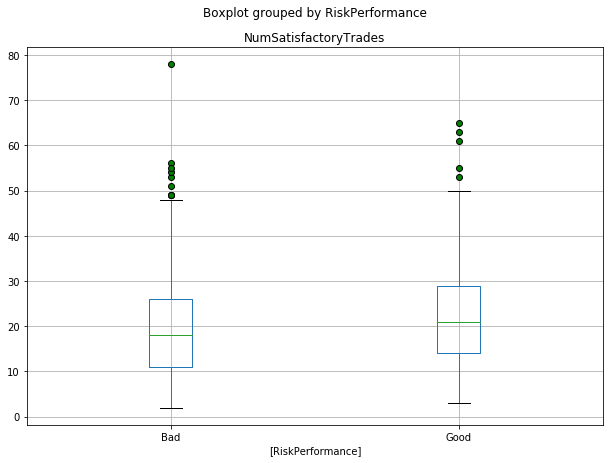

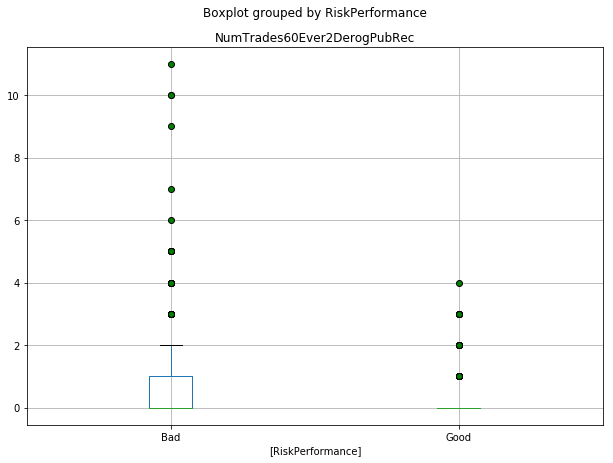

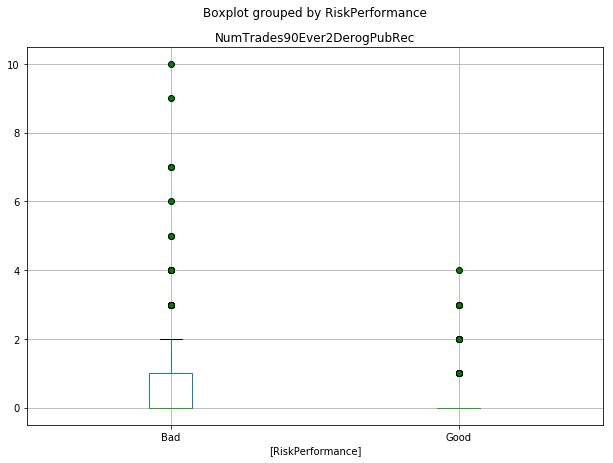

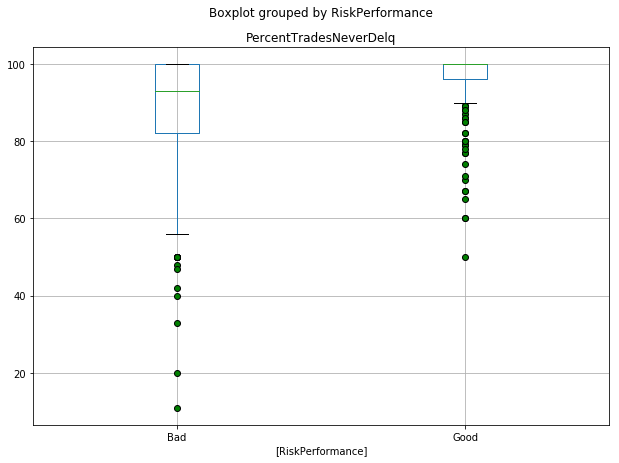

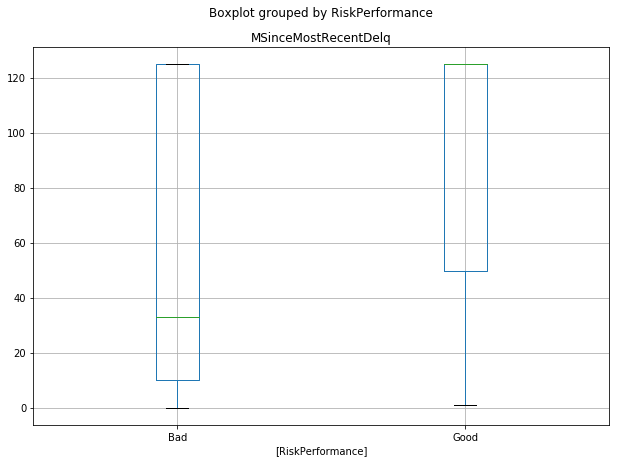

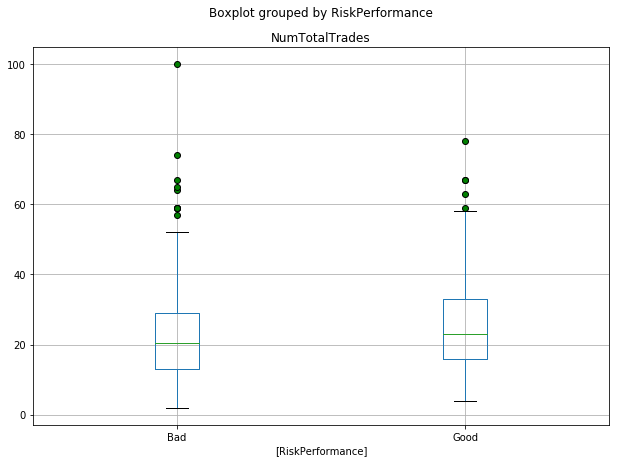

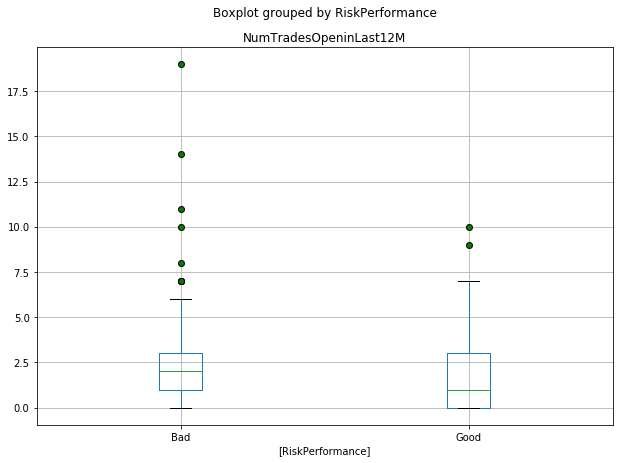

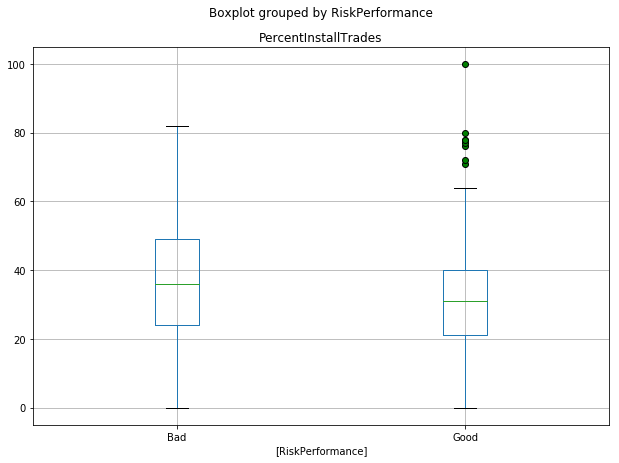

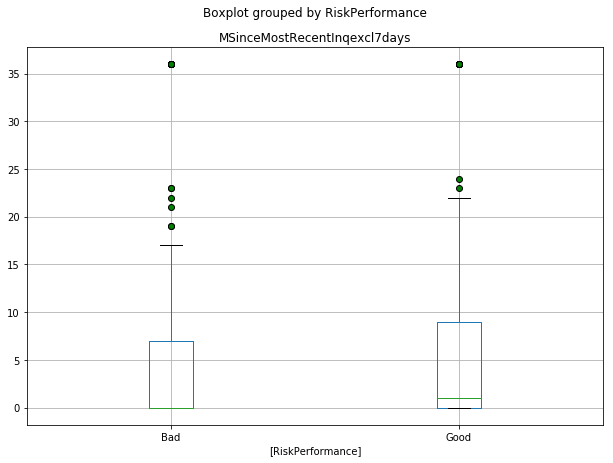

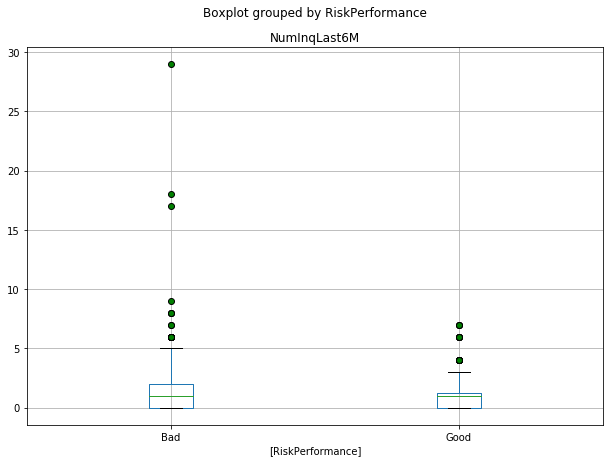

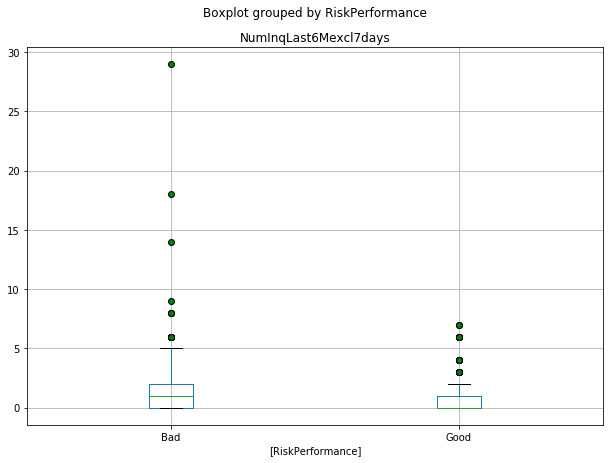

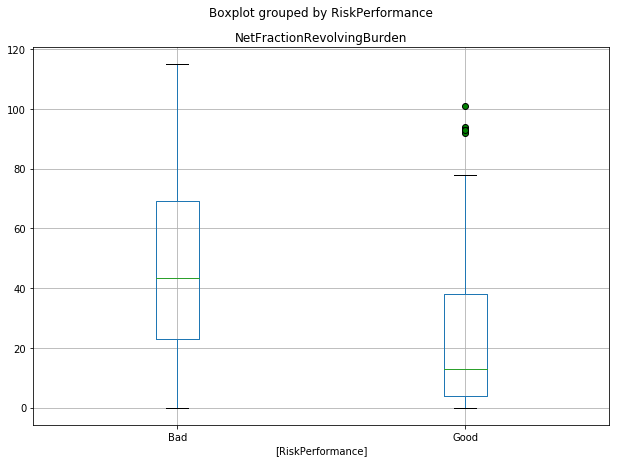

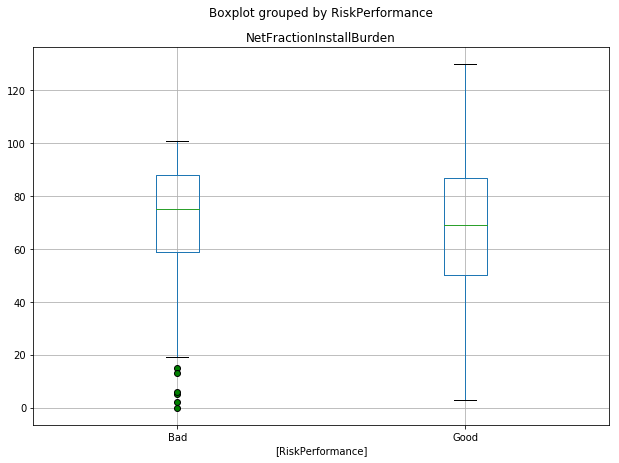

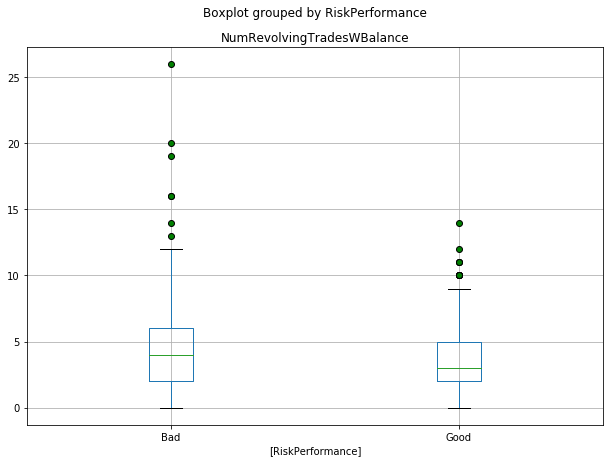

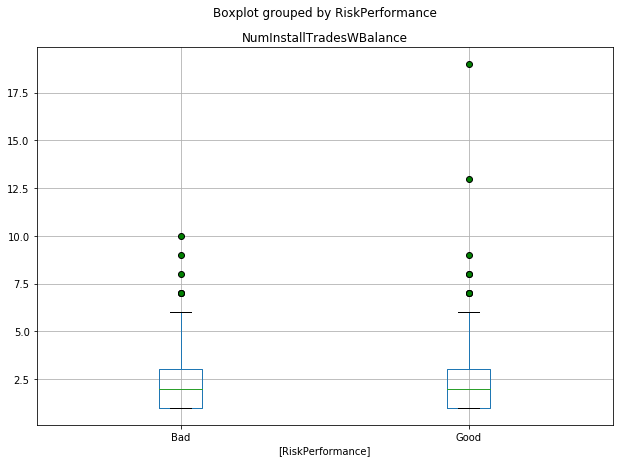

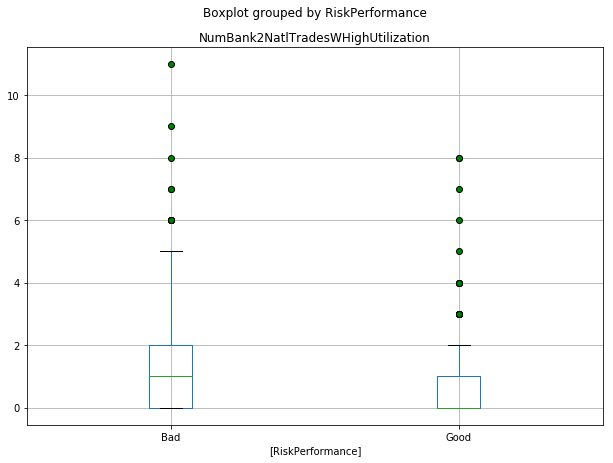

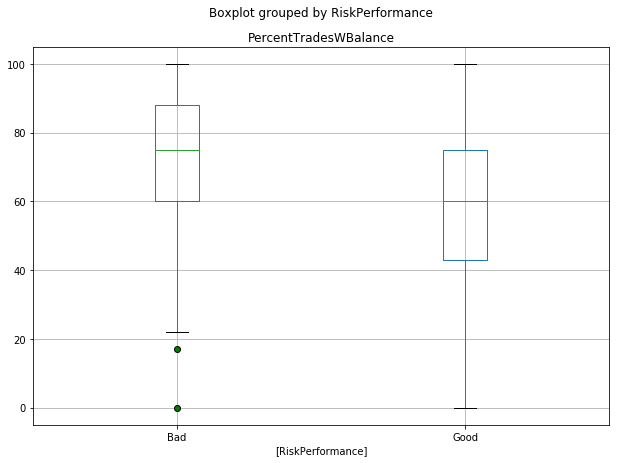

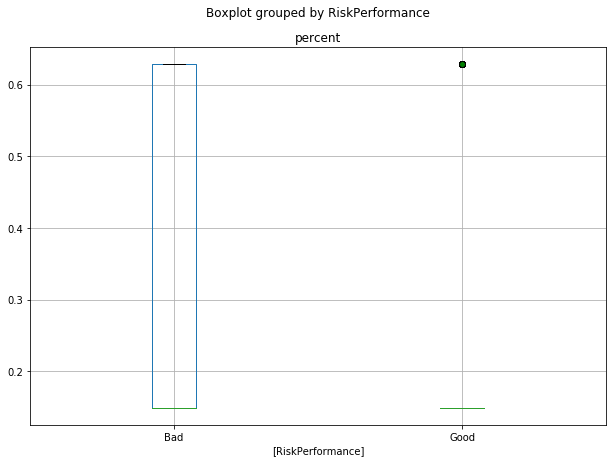

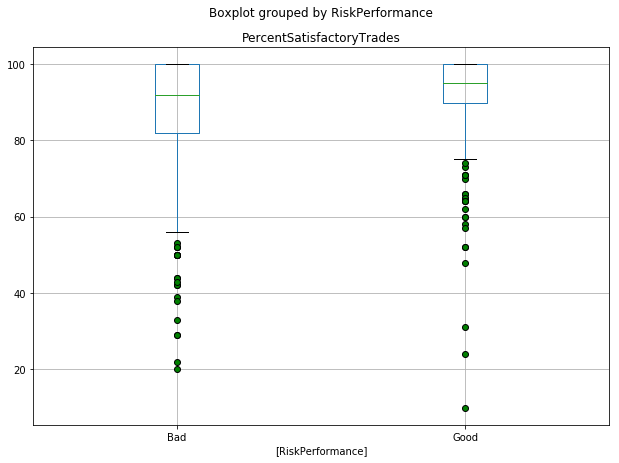

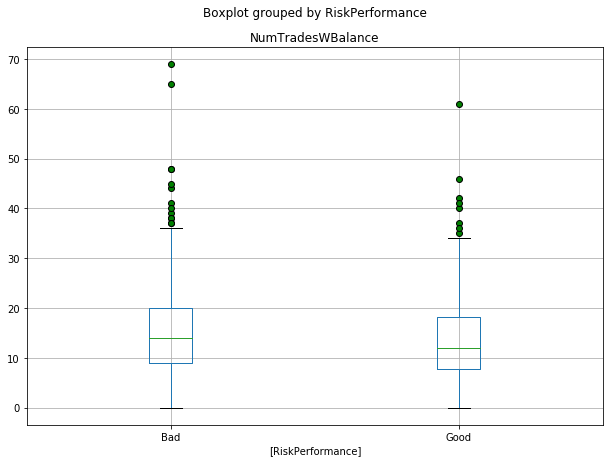

In [15]:
#For each continuous feature, plot its interaction with the target feature 
#(a plot for each pair of continuous feature and target feature). 
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6, linestyle='none')
for col in continuous_columns:
    bp = df_train.boxplot(column=[col], by=['RiskPerformance'], flierprops=flierprops, figsize=(10,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2465d8d0>]],
      dtype=object)

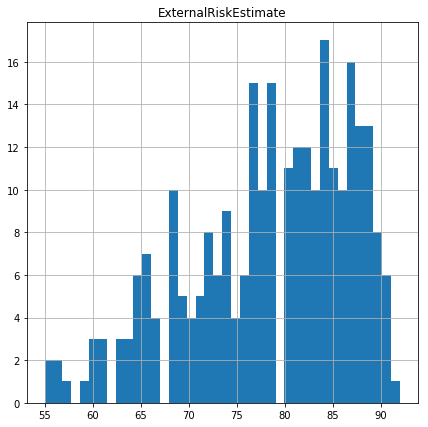

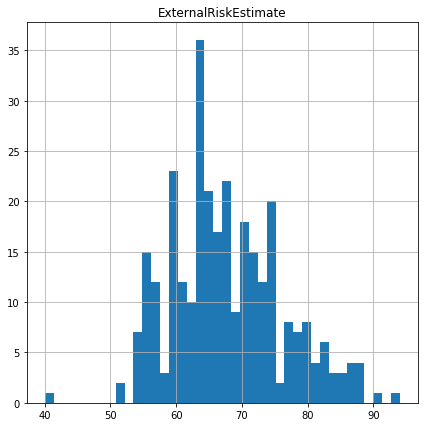

In [16]:
df_train[df_train['RiskPerformance'] == 'Good'][['ExternalRiskEstimate']].hist(figsize=(7,7), bins=40)
df_train[df_train['RiskPerformance'] == 'Bad'][['ExternalRiskEstimate']].hist(figsize=(7,7), bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23022eb8>]],
      dtype=object)

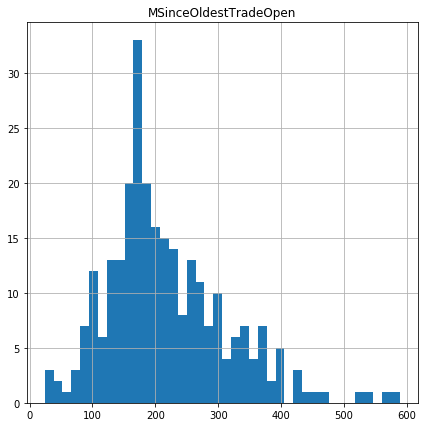

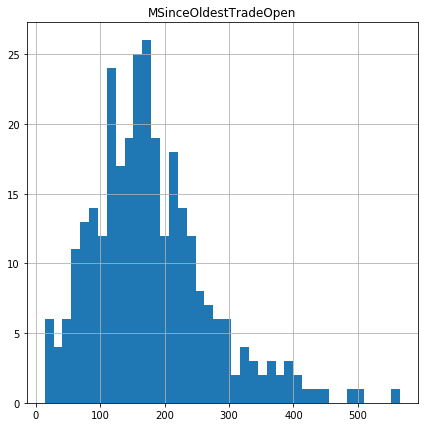

In [17]:
df_train[df_train['RiskPerformance'] == 'Good'][['MSinceOldestTradeOpen']].hist(figsize=(7,7), bins=40)
df_train[df_train['RiskPerformance'] == 'Bad'][['MSinceOldestTradeOpen']].hist(figsize=(7,7), bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23540320>]],
      dtype=object)

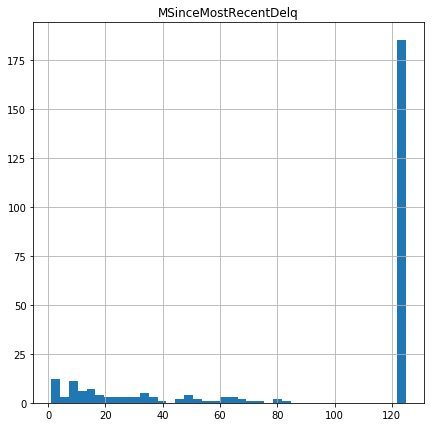

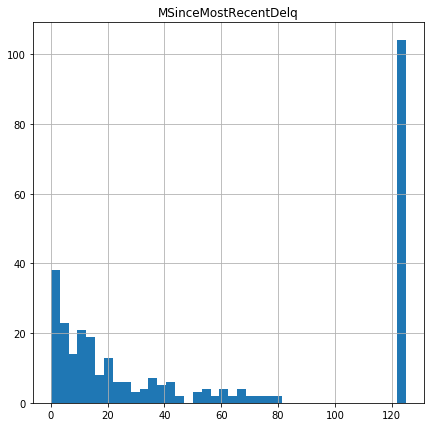

In [18]:
df_train[df_train['RiskPerformance'] == 'Good'][['MSinceMostRecentDelq']].hist(figsize=(7,7), bins=40)
df_train[df_train['RiskPerformance'] == 'Bad'][['MSinceMostRecentDelq']].hist(figsize=(7,7), bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a232f87f0>]],
      dtype=object)

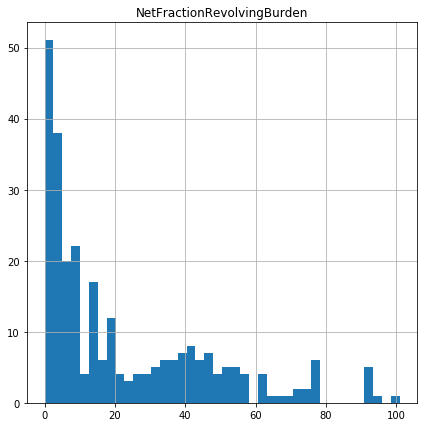

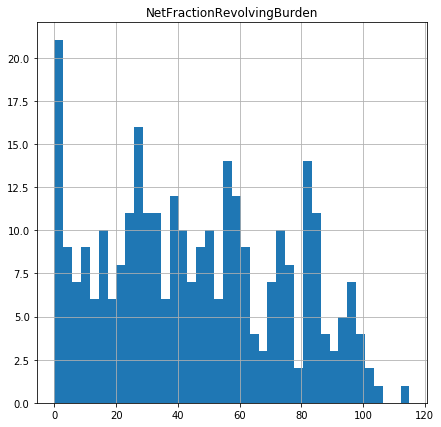

In [19]:
df_train[df_train['RiskPerformance'] == 'Good'][['NetFractionRevolvingBurden']].hist(figsize=(7,7), bins=40)
df_train[df_train['RiskPerformance'] == 'Bad'][['NetFractionRevolvingBurden']].hist(figsize=(7,7), bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23254400>]],
      dtype=object)

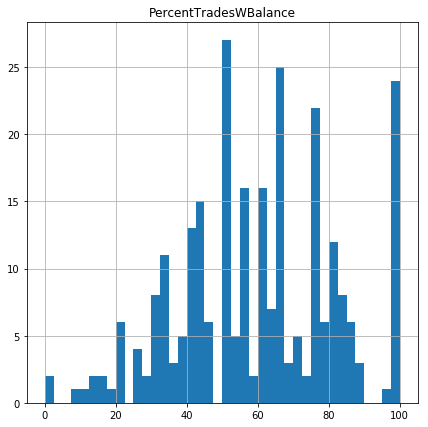

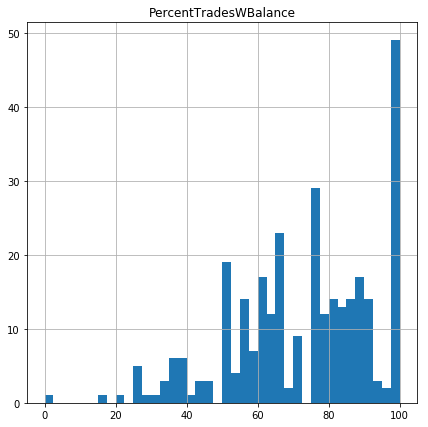

In [20]:
df_train[df_train['RiskPerformance'] == 'Good'][['PercentTradesWBalance']].hist(figsize=(7,7), bins=40)
df_train[df_train['RiskPerformance'] == 'Bad'][['PercentTradesWBalance']].hist(figsize=(7,7), bins=40)

### Discuss what you observe from these plots, e.g., which continuous features seem to be better at predicting the target feature? Choose a subset of continuous features you find promising (if any). Justify your choices.

from the plots of the interaction with the target feature and continuous features. I chosed the 5 continuous features that have the high correlation of riskPerformance,which seems to be better at predicting the target feature:

- **EnternalRiskEstimate**, the higher of ExternalRiskEstimate, the better of RiskPerformance, that's what we can see from the excel. The betther of the external risk estimate, the monotonically Decreasing, means the risk performance is better
- **MSinceOldestTradeOpen**, the higher of MSinceOldestTradeOpen, the better if RiskPerformance, that's what we can see from the excel. The longer of the month since oldest trade open, the monotonically Decreasing, means the risk performance is better
- **NetFractionRevolvingBurden**, the higher of the NetFractionRevolvingBurden, the worse of RiskPerformance,the worse if RiskPerformance, that's what we can see from the excel. The higher of net fraction revolving burden, the monotonically increasing, means the risk performance is worse
- **PercentTradesWBalance**, the higher of the PercentTrades by RiskPerformance, the worse of the RIskPerformance
- **MSinceMostRecentDelq**,the higher of the PercentTrades by MSinceMostRecentDelq, the worse better of the RIskPerformance. the longer of months since most recent delinquency, the higher of risk.

So I pick these 5 features to predict the target feature


### For each categorical feature, plot its pairwise interaction with the target feature.

MaxDelqEver
Index 	 Count
2 	 46
5 	 65
7 	 283
6 	 143
3 	 22
4 	 19


(0, 100)

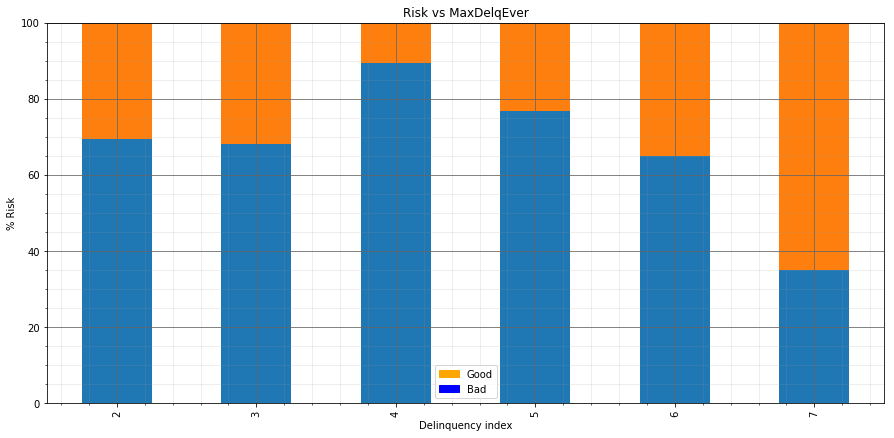

In [21]:
#Using code from the module lab
maxDelqEver = pd.unique(df_train["MaxDelqEver"].ravel())

# add new column and set values to zero
df_train['percent'] = 0

#print header
print("MaxDelqEver")
print("Index \t Count")

# for each delinquency category
for i in maxDelqEver:
    
    count = df_train[df_train["MaxDelqEver"] == i].count()['RiskPerformance']
    count_percentage = (1 / count) * 100
        
    # print out index vs count
    print(i, "\t", count)
    
    index_list = df_train[df_train['MaxDelqEver'] == i].index.tolist()
    for ind in index_list:
        df_train.loc[ind, 'percent'] = count_percentage
        
group = df_train[['percent','MaxDelqEver','RiskPerformance']].groupby(['MaxDelqEver','RiskPerformance']).sum()

my_plot = group.unstack().plot(kind='bar', stacked=True, title="Risk vs MaxDelqEver", figsize=(15,7), grid=True)

# add legend
red_patch = mpatches.Patch(color='orange', label='Good')
blue_patch = mpatches.Patch(color='blue', label='Bad')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# add gridlines
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

my_plot.set_xlabel("Delinquency index")
my_plot.set_ylabel("% Risk")
my_plot.set_ylim([0,100])

MaxDelq2PublicRecLast12M
Index 	 Count
6 	 93
2 	 14
7 	 458
5 	 10
4 	 2
3 	 1


(0, 100)

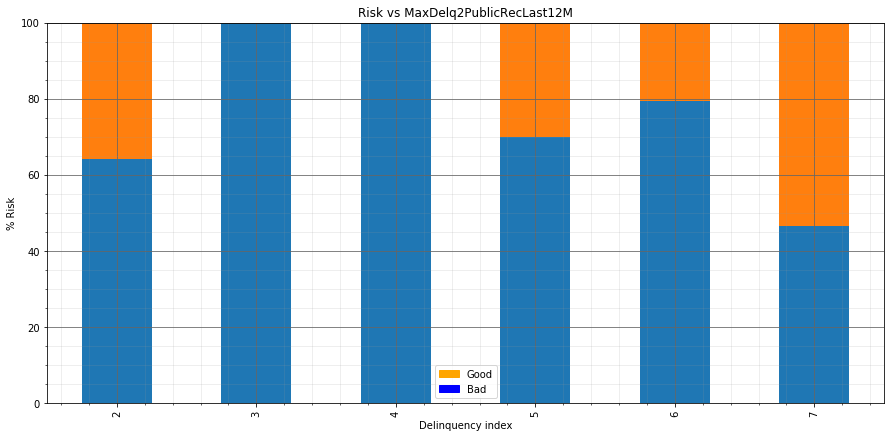

In [22]:
#Using code from the module lab
maxDelqEver = pd.unique(df_train["MaxDelq2PublicRecLast12M"].ravel())

# add new column and set values to zero
df_train['percent'] = 0

#print header
print("MaxDelq2PublicRecLast12M")
print("Index \t Count")

# for each income level
for i in maxDelqEver:
    
    count = df_train[df_train["MaxDelq2PublicRecLast12M"] == i].count()['RiskPerformance']
    count_percentage = (1 / count) * 100
    
    # print out index vs count
    print(i, "\t", count)
    
    index_list = df_train[df_train['MaxDelq2PublicRecLast12M'] == i].index.tolist()
    for ind in index_list:
        df_train.loc[ind, 'percent'] = count_percentage
        
group = df_train[['percent','MaxDelq2PublicRecLast12M','RiskPerformance']].groupby(['MaxDelq2PublicRecLast12M','RiskPerformance']).sum()

my_plot = group.unstack().plot(kind='bar', stacked=True, title="Risk vs MaxDelq2PublicRecLast12M", figsize=(15,7))

# add legend
red_patch = mpatches.Patch(color='orange', label='Good')
blue_patch = mpatches.Patch(color='blue', label='Bad')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# add gridlines
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set labels
my_plot.set_xlabel("Delinquency index")
my_plot.set_ylabel("% Risk")
my_plot.set_ylim([0,100])

DelqEver
Index 	 Count
True 	 295
False 	 283


(0, 100)

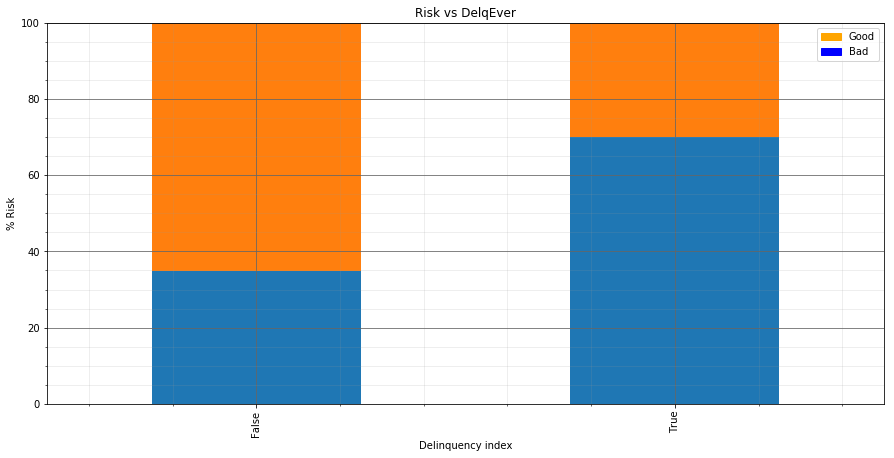

In [23]:
#Using code from the module lab
maxDelqEver = pd.unique(df_train["DelqEver"].ravel())

# add new column and set values to zero
df_train['percent'] = 0

#print header
print("DelqEver")
print("Index \t Count")

# for each income level
for i in maxDelqEver:
    
    count = df_train[df_train["DelqEver"] == i].count()['RiskPerformance']
    count_percentage = (1 / count) * 100
    
    # print out index vs count
    print(i, "\t", count)
    
    index_list = df_train[df_train['DelqEver'] == i].index.tolist()
    for ind in index_list:
        df_train.loc[ind, 'percent'] = count_percentage
        
group = df_train[['percent','DelqEver','RiskPerformance']].groupby(['DelqEver','RiskPerformance']).sum()

my_plot = group.unstack().plot(kind='bar', stacked=True, title="Risk vs DelqEver", figsize=(15,7))

# add legend
red_patch = mpatches.Patch(color='orange', label='Good')
blue_patch = mpatches.Patch(color='blue', label='Bad')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# add gridlines
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set labels
my_plot.set_xlabel("Delinquency index")
my_plot.set_ylabel("% Risk")
my_plot.set_ylim([0,100])

DelqLast12M
Index 	 Count
True 	 120
False 	 458


(0, 100)

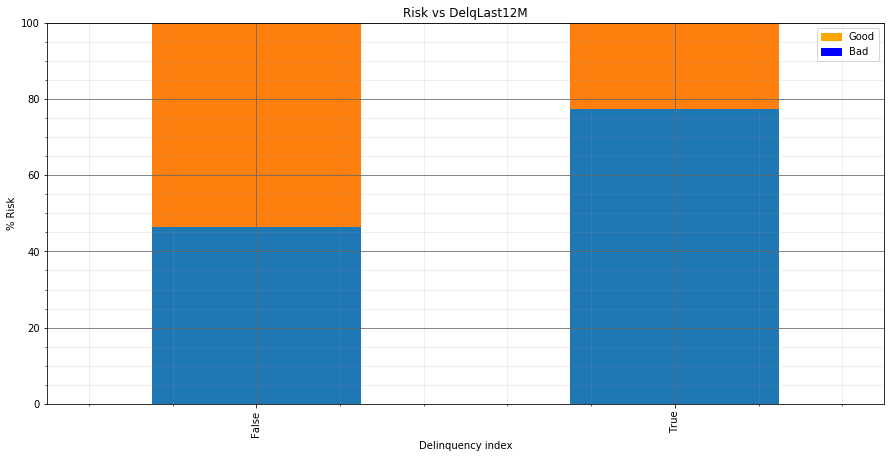

In [24]:
#Using code from the module lab
maxDelqEver = pd.unique(df_train["DelqLast12M"].ravel())

# add new column and set values to zero
df_train['percent'] = 0

#print header
print("DelqLast12M")
print("Index \t Count")

# for each income level
for i in maxDelqEver:
    
    count = df_train[df_train["DelqLast12M"] == i].count()['RiskPerformance']
    count_percentage = (1 / count) * 100
    
    # print out index vs count
    print(i, "\t", count)
    
    index_list = df_train[df_train['DelqLast12M'] == i].index.tolist()
    for ind in index_list:
        df_train.loc[ind, 'percent'] = count_percentage
        
group = df_train[['percent','DelqLast12M','RiskPerformance']].groupby(['DelqLast12M','RiskPerformance']).sum()

my_plot = group.unstack().plot(kind='bar', stacked=True, title="Risk vs DelqLast12M", figsize=(15,7))

# add legend
red_patch = mpatches.Patch(color='orange', label='Good')
blue_patch = mpatches.Patch(color='blue', label='Bad')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# add gridlines
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# set labels
my_plot.set_xlabel("Delinquency index")
my_plot.set_ylabel("% Risk")
my_plot.set_ylim([0,100])

### Discuss what knowledge you gain from these plots, e.g., which categorical features seem to be better at predicting the target feature? Choose a subset of categorical features you find promising (if any). Justify your choices.

These are all cateforical feature's pairwise plots, to show how much the different category influence to the target feature

##### "MaxDelq2PublicRecLast12M"
- 2    90 days delinquent
- 3    60 days delinquent
- 4    30 days delinquent
- 5,6  unknown delinquency
- 7    current and never delinquent

##### "MaxDelqEver"
- 2    derogatory comment
- 3    120+ days delinquent
- 4    90 days delinquent
- 5    60 days delinquent
- 6    30 days delinquent
- 7    unknown delinquency

 #### For "MaxDelqEver":
- We can see the stacked bar plot for Delinquency against the target risk outcome.
- There is no clear trend of decreasing likelihood of "bad" outcomes as delinquency scale improves.
- Only when we reach index 7, which means no delinquency do we see a significant drop.
- This indicates that a financial institution will look at any type of delinquency, either derogatory, 30, 60 or 90 days late in the same light.
- Judging from this we could derive a new feature of with a binary value, delinquent or not, without losing much information. 
- If entry has ever had a delinquency there is approx 60% likelihood of a bad risk marker
- If entry has never had delinquency there is approx 40% likelihood of a bad risk marker
 
 #### For "MaxDelq2PublicRecLast12M"
- We can see the stacked bar plot for Delinquency in the last 12 months against the target risk outcome.
- Similar to the "max delinquency ever" scale above, on first indication the figures are not as expected.
- There is no clear trend of decreasing number of "bad" outcomes as delinquency  scale improves.
- For some of the index vales there are very few entries. For example index 4 has count of 4, index 3 has a count of 2. Index 6 and 7 dominate in terms of count.
- Again this reinforces the view that a financial institution will look at any type of delinquency, either derogatory, 30, 60 or 90 days late in the same light.
- Similarly we could derive a new feature with a binary value, delinquent or not in last 12 months, without losing much information.
- If entry has had a delinquency in last 12 months there is approx 75% likelihood of a bad risk marker. This indicates a more recent delinquency has a stronger impact. (75% vs 60%) This is as expected.
- If entry has not had delinquency in last 12 months there is approx 50% likelihood of a bad risk marker. This indicates the narrower time scale for this measurement (12 months vs ever) has a bearing on higher risk (50% vs 40%). This is as expected.
    
 #### For "DelqLast12M"
- We can see the stacked bar plot for a entry during their history has ever been delinquent against the target risk outcome.
- people who DelqEver is false, more likely to have a good RiskPerformance
 
 #### For "DelqLast12M"
- We can see the stacked bar plot for a entry during the last 12 months has ever been delinquent against the target risk outcome.
- people who DelqLast12M is false, more likely to have a good RIskPerformance.

All in all, the following descriptive features will be put in my formation.

continuous features:

- EnternalRiskEstimate
- MSinceOldestTradeOpen
- MSinceMostRecentDelq
- NetFractionRevolvingBurden
- PercentTradesWBalance



categorical features:

- MaxDelqEver
- DelqEver
- MaxDelq2PublicRecLast12M
- DelqLast12M


# (2). [15] Predictive Modeling: Linear Regression.

### (2.1) On the training set, train a linear regression model to predict the target feature, using only the descriptive features selected in exercise (1) above. 


### Preparing the data

In [25]:
# Prepare the descriptive features from continous features on train set
cont_features=['ExternalRiskEstimate', 'MSinceOldestTradeOpen','MSinceMostRecentDelq', 'PercentTradesWBalance','NetFractionRevolvingBurden']
cont_features

['ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentDelq',
 'PercentTradesWBalance',
 'NetFractionRevolvingBurden']

##### I dummies the data to change the category feature to numerical features on train set

In [26]:
# Prepare the descriptive features from category features on train set
MaxDelqEver_dummies = pd.get_dummies(df_train['MaxDelqEver'], prefix='MaxDelqEver', drop_first=True)
print("MaxDelqEverDummies:", MaxDelqEver_dummies)
RiskPerformance_dummies = pd.get_dummies(df_train['RiskPerformance'], prefix='RiskPerformance', drop_first=True)
print("RiskPerformance:", RiskPerformance_dummies)
DelqEver_dummies = pd.get_dummies(df_train['DelqEver'], prefix='DelqEver', drop_first=True)
print("DelqEver:", DelqEver_dummies)
DelqLast12M_dummies = pd.get_dummies(df_train['DelqLast12M'], prefix='DelqLast12M', drop_first=True)
print("DelqLast12MDummies:", DelqLast12M_dummies)
MaxDelq2PublicRecLast12M_dummies = pd.get_dummies(df_train['MaxDelq2PublicRecLast12M'], prefix='MaxDelq2PublicRecLast12M', drop_first=True)
print("MaxDelq2PublicRecLast12MDummies:", MaxDelq2PublicRecLast12M_dummies)

cate_features = MaxDelqEver_dummies.columns.values.tolist()+DelqEver_dummies.columns.values.tolist() +DelqLast12M_dummies.columns.values.tolist() +MaxDelq2PublicRecLast12M_dummies.columns.values.tolist()
features = cont_features + cate_features

print("\nCont features: ", cont_features)
print("Categ features: ", cate_features)
print("Features: ", features)

MaxDelqEverDummies:      MaxDelqEver_3  MaxDelqEver_4  MaxDelqEver_5  MaxDelqEver_6  MaxDelqEver_7
0                0              0              0              0              0
1                0              0              1              0              0
2                0              0              0              0              1
3                0              0              0              0              0
4                0              0              0              0              1
5                0              0              0              0              1
6                0              0              0              0              1
7                0              0              0              0              1
8                0              0              0              0              1
9                0              0              1              0              0
10               0              0              0              0              1
11               0              

#### concatennate the numerical features with train set and drop the old categorical features on train set

In [27]:
# concatenate the new categorical features after the dummies and drop the old categorical features on train set
df_train = pd.concat([df_train, MaxDelqEver_dummies,RiskPerformance_dummies,DelqEver_dummies,MaxDelq2PublicRecLast12M_dummies,DelqLast12M_dummies], axis=1)

df_train = df_train.drop(['MaxDelqEver','MaxDelq2PublicRecLast12M','RiskPerformance','DelqEver'], axis = 1)
print(df_train)
df_train

     Unnamed: 0  ExternalRiskEstimate  MSinceOldestTradeOpen  \
0           440                    61                    183   
1           659                    56                    201   
2           321                    81                     58   
3           638                    71                    235   
4            87                    88                    286   
5           586                    77                    281   
6           289                    78                    185   
7           372                    81                    119   
8           472                    86                    189   
9           412                    55                    174   
10          183                    62                     58   
11          813                    40                    166   
12          294                    71                    200   
13          817                    73                    181   
14          388                    65   

,Unnamed: 0,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,MaxDelqEver_6,MaxDelqEver_7,RiskPerformance_Good,DelqEver_True,MaxDelq2PublicRecLast12M_3,MaxDelq2PublicRecLast12M_4,MaxDelq2PublicRecLast12M_5,MaxDelq2PublicRecLast12M_6,MaxDelq2PublicRecLast12M_7,DelqLast12M_True
0,440,61,183,26,111,3,1,1,60,7,...,0,0,1,1,0,0,0,1,0,1
1,659,56,201,12,67,25,2,1,85,0,...,0,0,0,1,0,0,0,0,0,1
2,321,81,58,34,49,5,0,0,100,125,...,0,1,1,0,0,0,0,0,1,0
3,638,71,235,4,71,32,1,1,94,83,...,0,0,1,1,0,0,0,0,1,0
4,87,88,286,76,133,4,0,0,100,125,...,0,1,1,0,0,0,0,0,1,0
5,586,77,281,9,90,37,0,0,100,125,...,0,1,0,0,0,0,0,0,1,0
6,289,78,185,12,63,13,0,0,100,125,...,0,1,1,0,0,0,0,0,1,0
7,372,81,119,8,54,22,0,0,100,125,...,0,1,0,0,0,0,0,0,1,0
8,472,86,189,2,76,19,0,0,100,125,...,0,1,1,0,0,0,0,0,1,0
9,412,55,174,19,86,9,1,0,70,2,...,0,0,0,1,0,0,1,0,0,1


In [28]:
# X as descriptive feature, target feature is y
Xtrain = df_train[features]
ytrain= df_train.RiskPerformance_Good

print("\nDescriptive features in X:\n", Xtrain)
print("\nTarget feature in y:\n", ytrain)


Descriptive features in X:
      ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentDelq  \
0                      61                    183                     7   
1                      56                    201                     0   
2                      81                     58                   125   
3                      71                    235                    83   
4                      88                    286                   125   
5                      77                    281                   125   
6                      78                    185                   125   
7                      81                    119                   125   
8                      86                    189                   125   
9                      55                    174                     2   
10                     62                     58                   125   
11                     40                    166                     1   
12       

### Training the model

### - (2.2) Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model). 

#### Train the train set and get a model and get the coefficient

In [29]:
# Train the train set and get a model
multiple_linreg = LinearRegression().fit(Xtrain, ytrain)

# Print the weights learned for each feature.
print("Features: \n", features)
print("Coeficients: \n", multiple_linreg.coef_)
print("\nIntercept: \n", multiple_linreg.intercept_)
print("Features and coeficients:", list(zip(features, multiple_linreg.coef_)))

Features: 
 ['ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'MSinceMostRecentDelq', 'PercentTradesWBalance', 'NetFractionRevolvingBurden', 'MaxDelqEver_3', 'MaxDelqEver_4', 'MaxDelqEver_5', 'MaxDelqEver_6', 'MaxDelqEver_7', 'DelqEver_True', 'DelqLast12M_True', 'MaxDelq2PublicRecLast12M_3', 'MaxDelq2PublicRecLast12M_4', 'MaxDelq2PublicRecLast12M_5', 'MaxDelq2PublicRecLast12M_6', 'MaxDelq2PublicRecLast12M_7']
Coeficients: 
 [ 2.13614815e-02  6.52439860e-04 -6.07559615e-04  3.15002695e-04
 -1.58267852e-03 -3.95810060e-02 -2.34491299e-01 -1.57534094e-01
 -7.04435227e-02  3.62655613e-02 -3.62655613e-02  1.04391988e-01
 -5.10343048e-01 -3.91754988e-01 -2.98219805e-02 -1.83499353e-01
 -1.04391988e-01]

Intercept: 
 -0.9950607118312428
Features and coeficients: [('ExternalRiskEstimate', 0.021361481527098627), ('MSinceOldestTradeOpen', 0.0006524398600834378), ('MSinceMostRecentDelq', -0.0006075596152672783), ('PercentTradesWBalance', 0.00031500269493346124), ('NetFractionRevolvingBurden', -0.

### Discussion  （interpret the model）

- Features are a few features that I've picked out through plot that have a significant impact on the target feature: Risk Performance, and I'm training these features to predict the model.
- coefficients are the numerical or constant quantity placed before and multiplying the variable in an algebraic expression
- This model linear regression is a set of weights (one weight per feature, plus an extra weight called the bias or the intercept) on a dataset called the training set.

The model have a positive relationship with ExternalRiskEstimate, MSinceOldestTradeOpen, PercentTradesWBalance, MaxDelqEver_7, and a negative relationship with MSinceMostRecentDelq, NetFractionRevolvingBurden, MaxDelqEver_3, MaxDelqEver_4, MaxDelqEver_5, MaxDelqEver_6, DelqEver_True


The equation for Linear regression model is: $RiskPerformance = -0.9589666637977864 + 0.02008827 * ExternalRiskEstimate + 0.00067029 * MSinceOldestTradeOpen + ...- 0.04480531*DelqEver\_True$

### - (2.3) Print the predicted target feature value for the first 100 training examples. 

In [30]:
#  Print the predicted target feature value for the first 100 training examples. 
multiple_linreg_predictions = multiple_linreg.predict(Xtrain)
pd.DataFrame(multiple_linreg_predictions, columns=['Predicted']).head(100)

,Predicted
0,0.190489
1,0.235862
2,0.638332
3,0.431492
4,0.944532
5,0.654757
6,0.608045
7,0.645578
8,0.837923
9,0.111722


#### Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 

#### The model doesn't have order after trained, so we need to reset the inde first

In [31]:
# set the index of ytrain
ytrain=ytrain.reset_index(drop=True)
ytrain

0      1
1      0
2      1
3      1
4      1
5      0
6      1
7      0
8      1
9      0
10     0
11     0
12     0
13     0
14     0
15     1
16     1
17     1
18     0
19     0
20     1
21     1
22     0
23     1
24     0
25     0
26     0
27     0
28     0
29     0
      ..
548    1
549    1
550    1
551    1
552    0
553    0
554    0
555    0
556    0
557    1
558    1
559    0
560    0
561    1
562    1
563    1
564    1
565    1
566    0
567    0
568    1
569    0
570    0
571    0
572    1
573    1
574    1
575    0
576    0
577    0
Name: RiskPerformance_Good, Length: 578, dtype: uint8

#### Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each on the train set

In [32]:
# Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 
predicted_norm = pd.DataFrame(multiple_linreg_predictions, columns=['Predicted'])

predicted_norm.loc[predicted_norm.Predicted < 0.5, 'predicted_thres'] = 0 
predicted_norm.loc[predicted_norm.Predicted >= 0.5, 'predicted_thres'] = 1 
predicted_norm = predicted_norm.drop("Predicted", axis=1)

In [33]:
#sort the unordered prediction
predicted_norm=predicted_norm.sort_index()
predicted_norm

,predicted_thres
0,0.0
1,0.0
2,1.0
3,0.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,0.0


#### Print the predicted class for the first 100 examples. 

In [34]:
# Print the predicted class for the first 100 examples. 
print(predicted_norm.head(100))

    predicted_thres
0               0.0
1               0.0
2               1.0
3               0.0
4               1.0
5               1.0
6               1.0
7               1.0
8               1.0
9               0.0
10              0.0
11              0.0
12              0.0
13              0.0
14              0.0
15              1.0
16              1.0
17              1.0
18              0.0
19              0.0
20              1.0
21              0.0
22              0.0
23              0.0
24              0.0
25              1.0
26              1.0
27              0.0
28              0.0
29              1.0
..              ...
70              1.0
71              0.0
72              0.0
73              0.0
74              1.0
75              0.0
76              0.0
77              0.0
78              0.0
79              0.0
80              0.0
81              0.0
82              0.0
83              0.0
84              1.0
85              0.0
86              0.0
87              0.0


#### Print the classification evaluation measures computed on the training set  (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.

In [35]:
from sklearn.metrics import classification_report
# Print the classification evaluation measures computed on the training set 
# (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
print("Accuracy: ", metrics.accuracy_score(ytrain, predicted_norm))
print("Confusion matrix: \n", metrics.confusion_matrix(ytrain, predicted_norm))
print("Classification report:\n ", metrics.classification_report(ytrain, predicted_norm))

Accuracy:  0.7716262975778547
Confusion matrix: 
 [[248  58]
 [ 74 198]]
Classification report:
                precision    recall  f1-score   support

           0       0.77      0.81      0.79       306
           1       0.77      0.73      0.75       272

   micro avg       0.77      0.77      0.77       578
   macro avg       0.77      0.77      0.77       578
weighted avg       0.77      0.77      0.77       578



### Discuss:

After using the train set to test the model, the accuracy reached 0.77.  In our case we have 578 examples and the predictions is correct on about 476 of them. The accuracy is relatively high, the higher means the predictions are more accurate.

The **confusion matrix** shows the actual and predicted labels from a classification problem
- 248 in position TN, which is data points labeled as negative that is actually negative. 58 is in position FP, which is data points labeled as positive that is actually negative. 74 is in position FN, which is data points labeled as negative that are actually positive. 198 is in position TP, which is data points labeled as positive that are actually positive.
- there are two classes, and 74 + 198 = 272 of them have good RiskPerformance.
- there are 248 + 58 +74 +198 =578 statistics in total, and it has predicted for 578 times, the correct predict is 248 + 198 = 447 times. 
- The TPR of evaluation is when actual value is spam, 0.76 of the data are predict correct, the FPR is when actual value is ham, the 0.167 of the data predict wrong
- **Precision** is the ability of a classification model to return only relevant instances. The equation of it is correctly predicted positive(TP) / predicted positive(TP+FP), 0.81 of bad risk performance is when we predict 100 people, there are 81 people have bad risk performance, same as the good risk performance. the higher of TP, the prediction is more precise.
- **Recall** is the ability of a classification model to identify all relevant instances. the equation of it is correctly predicted positive (TP)/ actual positive(TP+FN), 0.79 for bad risk performance  means we find out 79 bad risk performance people in 100 bad risk performance  people, same as good risk performance.
- **F1 score** is the single metric that combines recall and precision using the harmonic mean, weighted average of Precision and Recall. The equation is  2*(Recall * Precision) / (Recall + Precision) it takes both the precision p and the recall r into consideration. 

Overall, the model is slightly better at predicting 'RiskPerformance_bad' class than 'RiskPerformance_good' class.

### - (2.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

### prepare the data

In [36]:
# Prepare the descriptive features from continous features on test set
cont_features=['ExternalRiskEstimate', 'MSinceOldestTradeOpen','MSinceMostRecentDelq', 'PercentTradesWBalance','NetFractionRevolvingBurden']
cont_features

['ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentDelq',
 'PercentTradesWBalance',
 'NetFractionRevolvingBurden']

##### I dummies the data to change the category feature to numerical features on test set

In [37]:
# Prepare the descriptive features from category features on train set
MaxDelqEver_dummies = pd.get_dummies(df_test['MaxDelqEver'], prefix='MaxDelqEver', drop_first=True)
print("MaxDelqEverDummies:", MaxDelqEver_dummies)
RiskPerformance_dummies = pd.get_dummies(df_test['RiskPerformance'], prefix='RiskPerformance', drop_first=True)
print("RiskPerformance:", RiskPerformance_dummies)
DelqEver_dummies = pd.get_dummies(df_test['DelqEver'], prefix='DelqEver', drop_first=True)
print("DelqEver:", DelqEver_dummies)
DelqLast12M_dummies = pd.get_dummies(df_test['DelqLast12M'], prefix='DelqLast12M', drop_first=True)
print("DelqLast12MDummies:", DelqLast12M_dummies)
MaxDelq2PublicRecLast12M_dummies = pd.get_dummies(df_test['MaxDelq2PublicRecLast12M'], prefix='MaxDelq2PublicRecLast12M', drop_first=True)
print("MaxDelq2PublicRecLast12MDummies:", MaxDelq2PublicRecLast12M_dummies)

cate_features = MaxDelqEver_dummies.columns.values.tolist()+DelqEver_dummies.columns.values.tolist() +DelqLast12M_dummies.columns.values.tolist() +MaxDelq2PublicRecLast12M_dummies.columns.values.tolist()
features = cont_features + cate_features

print("\nCont features: ", cont_features)
print("Categ features: ", cate_features)
print("Features: ", features)


MaxDelqEverDummies:      MaxDelqEver_3  MaxDelqEver_4  MaxDelqEver_5  MaxDelqEver_6  MaxDelqEver_7
0                0              0              0              0              1
1                0              0              0              0              1
2                0              0              0              0              1
3                0              0              0              1              0
4                0              0              1              0              0
5                0              0              0              0              0
6                0              0              0              0              1
7                0              0              0              0              1
8                0              0              0              0              1
9                0              0              0              1              0
10               0              0              0              0              1
11               0              

MaxDelq2PublicRecLast12MDummies:      MaxDelq2PublicRecLast12M_3  MaxDelq2PublicRecLast12M_4  \
0                             0                           0   
1                             0                           0   
2                             0                           0   
3                             0                           0   
4                             0                           0   
5                             0                           0   
6                             0                           0   
7                             0                           0   
8                             0                           0   
9                             0                           0   
10                            0                           0   
11                            0                           0   
12                            0                           0   
13                            0                           0   
14                    

#### concatennate the numerical features with train set and drop the old categorical features on test set

In [38]:
# concatenate the new categorical features after the dummies and drop the old categorical features on train set
df_test = pd.concat([df_test, MaxDelqEver_dummies,RiskPerformance_dummies,DelqEver_dummies,MaxDelq2PublicRecLast12M_dummies,DelqLast12M_dummies], axis=1)

df_test = df_test.drop(['MaxDelqEver','MaxDelq2PublicRecLast12M','RiskPerformance','DelqEver','DelqLast12M'], axis = 1)
print(df_test)

     Unnamed: 0  ExternalRiskEstimate  MSinceOldestTradeOpen  \
0           376                    69                    153   
1           110                    90                    200   
2           367                    63                     57   
3           203                    71                    193   
4           260                    65                    148   
5           620                    70                    366   
6           532                    89                    283   
7           365                    82                    118   
8           173                    72                    198   
9           340                    63                    349   
10          238                    82                    163   
11          465                    80                     90   
12          165                    77                    473   
13          770                    65                    130   
14          213                    66   

In [39]:
# X as descriptive feature, target feature is y
Xtest = df_test[features]
ytest = df_test.RiskPerformance_Good

print("\nDescriptive features in X:\n", Xtest)
print("\nTarget feature in y:\n", ytest)


Descriptive features in X:
      ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentDelq  \
0                      69                    153                   125   
1                      90                    200                   125   
2                      63                     57                   125   
3                      71                    193                    11   
4                      65                    148                    11   
5                      70                    366                     1   
6                      89                    283                   125   
7                      82                    118                   125   
8                      72                    198                   125   
9                      63                    349                    16   
10                     82                    163                   125   
11                     80                     90                   125   
12       

### Testing the model
Using the trained model to predict the target feature RiskPerformance, given the descriptive features  ExternalRiskEstimate, MSinceOldestTradeOpen, MSinceMostRecentDelq, NetFractionRevolvingBurden, PercentTradesWBalance,MaxDelqEver, RiskPerformance_Good, DelqEver,MaxDelq2PublicRecLast12M,DelqLast12M

In [40]:
multiple_linreg_predictions = multiple_linreg.predict(Xtest)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([ytest, pd.DataFrame(multiple_linreg_predictions, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg)


Predictions with multiple linear regression: 

     RiskPerformance_Good  Predicted
0                       0   0.423401
1                       1   0.933089
2                       0   0.162991
3                       1   0.414406
4                       0   0.213457
5                       0   0.808399
6                       1   0.956100
7                       1   0.699892
8                       1   0.490624
9                       0   0.254895
10                      0   0.707694
11                      0   0.550893
12                      1   0.809474
13                      0   0.156769
14                      0   0.187635
15                      0   0.363251
16                      0  -0.000126
17                      1   0.501310
18                      0   0.151450
19                      1   0.648880
20                      0   0.245745
21                      1   0.657496
22                      1   0.412419
23                      0   0.362210
24                      0  

#### Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each on the test set 

In [41]:
# Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 
predicted_normtest = pd.DataFrame(multiple_linreg_predictions, columns=['Predicted'])

predicted_normtest.loc[predicted_normtest.Predicted < 0.5, 'predicted_thres'] = 0 
predicted_normtest.loc[predicted_normtest.Predicted >= 0.5, 'predicted_thres'] = 1 
predicted_normtest = predicted_normtest.drop("Predicted", axis=1)
predicted_normtest=predicted_normtest.sort_index()
predicted_normtest

,predicted_thres
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0
5,1.0
6,1.0
7,1.0
8,0.0
9,0.0


#### Print the classification evaluation measures computed on the testing set  (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) 

In [42]:
from sklearn.metrics import classification_report
# Print the classification evaluation measures computed on the training set 
# (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
print("Accuracy: ", metrics.accuracy_score(ytest, predicted_normtest))
print("Confusion matrix: \n", metrics.confusion_matrix(ytest, predicted_normtest))
print("Classification report:\n ", metrics.classification_report(ytest, predicted_normtest))

Accuracy:  0.6746987951807228
Confusion matrix: 
 [[77 39]
 [42 91]]
Classification report:
                precision    recall  f1-score   support

           0       0.65      0.66      0.66       116
           1       0.70      0.68      0.69       133

   micro avg       0.67      0.67      0.67       249
   macro avg       0.67      0.67      0.67       249
weighted avg       0.68      0.67      0.67       249



### Discuss: Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation.

- The two set are both have over 65 percent and less than 80 accuracy, which is very good, without underfitting or overfitting.
- The accuracy of "train set" is higher than that of "testset", which is a normal phenomenon, because the data volume of "train set" is 70%, while that of "test" is only 30%.
- The TPR of evaluation is when actual value is spam, 0.68 of the data are predict correct, the FPR is when actual value is ham, the 0.31 of the data predict wrong. The difference between train and teston the TPR and FPR,the higher of TPR, the better accuracy, the higher of FRP, the lower of the accuracy

- The train set's **Precision** is higher than test set. The train set's ability of a classification model to return only relevant instances is better than test set.
- The train set's **Recall** is higher than test set. The train set's ability of a classification model to identify all relevant instances is better than test set.
- The train set's **F1 score** is higher than test set. The train set's weight the average of precision and recall is better

The overall "Accuracy", "precision", "recall", "f1-score" of train set are all higher than test set.

### Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [43]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#### THe method od cross-validation model is a different one from the linear regression, it need to use the whole dataset to predict

In [44]:
# check the whole dataframe features
X.columns

Index(['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance',
       'percent', 'DelqEver', 'DelqLast12M', 'PercentSatisfactoryTrades',
       'NumTradesWBalance'],
      dtype='object')

In [45]:
features

['ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentDelq',
 'PercentTradesWBalance',
 'NetFractionRevolvingBurden',
 'MaxDelqEver_3',
 'MaxDelqEver_4',
 'MaxDelqEver_5',
 'MaxDelqEver_6',
 'MaxDelqEver_7',
 'DelqEver_True',
 'DelqLast12M_True',
 'MaxDelq2PublicRecLast12M_3',
 'MaxDelq2PublicRecLast12M_4',
 'MaxDelq2PublicRecLast12M_5',
 'MaxDelq2PublicRecLast12M_6',
 'MaxDelq2PublicRecLast12M_7']

In [46]:
X.head()

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,percent,DelqEver,DelqLast12M,PercentSatisfactoryTrades,NumTradesWBalance
0,78,227,5,92,28,0,0,100,125,7,...,79.0,3,2,2,63,0.149031,False,False,65.0,27
1,77,101,13,63,31,0,0,100,125,7,...,3.0,2,2,1,40,0.149031,False,False,97.0,12
2,81,131,16,59,19,1,0,90,15,7,...,NaN,1,1,0,25,0.149031,True,False,95.0,5
3,73,280,8,104,49,0,0,96,60,7,...,91.0,4,2,1,43,0.149031,True,False,94.0,22
4,68,220,9,69,27,0,0,100,125,7,...,59.0,4,4,2,100,0.149031,False,False,100.0,27


In [47]:
y.head()

0    Good
1    Good
2     Bad
3    Good
4     Bad
Name: RiskPerformance, dtype: category
Categories (2, object): [Bad, Good]

#### Dummies the categorical features to numerical features on the whole dataset

In [48]:
# Prepare the descriptive features from category features
MaxDelqEver_dummies = pd.get_dummies(X['MaxDelqEver'], prefix='MaxDelqEver', drop_first=True)
print("MaxDelqEverDummies:", MaxDelqEver_dummies)

DelqEver_dummies = pd.get_dummies(X['DelqEver'], prefix='DelqEver', drop_first=True)
print("DelqEver:", DelqEver_dummies)

DelqLast12M_dummies = pd.get_dummies(X['DelqLast12M'], prefix='DelqLast12M', drop_first=True)
print("DelqLast12MDummies:", DelqLast12M_dummies)
MaxDelq2PublicRecLast12M_dummies = pd.get_dummies(X['MaxDelq2PublicRecLast12M'], prefix='MaxDelq2PublicRecLast12M', drop_first=True)
print("MaxDelq2PublicRecLast12MDummies:", MaxDelq2PublicRecLast12M_dummies)

cate_features = MaxDelqEver_dummies.columns.values.tolist()+DelqEver_dummies.columns.values.tolist() +DelqLast12M_dummies.columns.values.tolist() +MaxDelq2PublicRecLast12M_dummies.columns.values.tolist()
features = cont_features + cate_features


print("\nCont features: ", cont_features)
print("Categ features: ", cate_features)
print("Features: ", features)


MaxDelqEverDummies:      MaxDelqEver_3  MaxDelqEver_4  MaxDelqEver_5  MaxDelqEver_6  MaxDelqEver_7
0                0              0              0              0              1
1                0              0              0              0              1
2                0              0              1              0              0
3                0              0              0              1              0
4                0              0              0              0              1
5                0              0              1              0              0
6                0              0              0              1              0
7                0              0              0              0              1
8                1              0              0              0              0
9                0              0              0              0              0
10               0              0              0              0              1
11               0              

In [49]:
y = pd.DataFrame(y)

In [50]:
y.head()

,RiskPerformance
0,Good
1,Good
2,Bad
3,Good
4,Bad


#### Dummies the target feature

In [51]:
RiskPerformance_dummies = pd.get_dummies(y['RiskPerformance'], prefix='RiskPerformance', drop_first=True)

y = pd.concat([y, RiskPerformance_dummies], axis=1)

y = y.drop('RiskPerformance', axis = 1)
y.head()

,RiskPerformance_Good
0,1
1,1
2,0
3,1
4,0


#### concatenate the numerical features and drop the old categorical features

In [52]:
X = pd.concat([X, MaxDelqEver_dummies,RiskPerformance_dummies,DelqEver_dummies,MaxDelq2PublicRecLast12M_dummies,DelqLast12M_dummies], axis=1)

X = X.drop(['MaxDelqEver','MaxDelq2PublicRecLast12M','DelqEver','DelqLast12M'], axis = 1)
X.head()

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,NumTotalTrades,...,MaxDelqEver_6,MaxDelqEver_7,RiskPerformance_Good,DelqEver_True,MaxDelq2PublicRecLast12M_3,MaxDelq2PublicRecLast12M_4,MaxDelq2PublicRecLast12M_5,MaxDelq2PublicRecLast12M_6,MaxDelq2PublicRecLast12M_7,DelqLast12M_True
0,78,227,5,92,28,0,0,100,125,43,...,0,1,1,0,0,0,0,0,1,0
1,77,101,13,63,31,0,0,100,125,32,...,0,1,1,0,0,0,0,0,1,0
2,81,131,16,59,19,1,0,90,15,20,...,0,0,0,1,0,0,0,0,1,0
3,73,280,8,104,49,0,0,96,60,52,...,1,0,1,1,0,0,0,0,1,0
4,68,220,9,69,27,0,0,100,125,27,...,0,1,0,0,0,0,0,0,1,0


#### Use cross-validation to train the model, and get the prediction result, and threshold the result

In [53]:
# Also compare these results with a cross-validated model 
# (i.e., a new model trained and evaluated using cross-validation on the full dataset).
predictions = cross_val_predict(LinearRegression(), X[features], y, cv=5)

print(predictions)
for i in range(len(predictions)):
    if predictions[i] > 0.5:
        predictions[i] = 1
    else:
        predictions[i] = 0

predictions

[[ 6.23400990e-01]
 [ 5.36111208e-01]
 [ 5.60849449e-01]
 [ 4.40455743e-01]
 [ 3.60458391e-01]
 [ 2.36494822e-01]
 [ 4.47884685e-01]
 [ 7.20049099e-01]
 [-1.27024592e-01]
 [ 2.78811288e-01]
 [ 6.20279416e-01]
 [ 3.90008967e-01]
 [ 1.60299339e-01]
 [ 7.42445137e-01]
 [ 1.84516378e-01]
 [ 3.64329328e-01]
 [ 6.77072248e-01]
 [ 4.09756709e-01]
 [ 1.76657579e-01]
 [ 1.43898765e-01]
 [ 3.70255318e-01]
 [ 5.32419767e-01]
 [ 1.25141377e-01]
 [ 2.79272410e-01]
 [ 5.55924207e-01]
 [ 9.68309550e-02]
 [-6.93330913e-02]
 [ 2.34313716e-01]
 [ 4.37703361e-01]
 [ 6.43943179e-01]
 [ 5.97673820e-01]
 [ 3.33222563e-01]
 [ 8.73186688e-01]
 [ 1.42763565e-01]
 [ 2.89700573e-01]
 [ 3.98795193e-01]
 [ 9.21018254e-01]
 [ 5.52422093e-01]
 [ 1.07740694e+00]
 [ 5.49643726e-01]
 [ 4.71938902e-01]
 [ 3.56180867e-01]
 [ 7.40832320e-01]
 [ 4.82087401e-01]
 [ 3.20291307e-01]
 [ 8.62114838e-01]
 [ 1.02725580e+00]
 [ 3.39496753e-01]
 [ 8.06790115e-01]
 [ 5.07932974e-01]
 [ 6.71987322e-01]
 [ 2.45728253e-01]
 [ 3.8649969

array([[1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],

#### Print the classification evaluation measures computed on the training set  (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far

In [54]:
from sklearn.metrics import classification_report
# Print the classification evaluation measures computed on the training set 
# (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
print("Accuracy: ", metrics.accuracy_score(y, predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y, predictions))
print("Classification report:\n ", metrics.classification_report(y, predictions))

Accuracy:  0.7376058041112454
Confusion matrix: 
 [[321 101]
 [116 289]]
Classification report:
                precision    recall  f1-score   support

           0       0.73      0.76      0.75       422
           1       0.74      0.71      0.73       405

   micro avg       0.74      0.74      0.74       827
   macro avg       0.74      0.74      0.74       827
weighted avg       0.74      0.74      0.74       827



# Discuss:

After using cross-validation to test the model, we could set he results are not much different with full data, the accuracy reached 0.74, it's between the train set and test set. 


The **confusion matrix** shows the actual and predicted labels from a classification problem
- 323 in position TN, which is data points labeled as negative that are actually negative. 99 is in position FP, which is data points labeled as positive that are actually negative. 115 is in position FN, which is data points labeled as negative that are actually positive. 290 is in position TP, which is data points labeled as positive that are actually positive.
- there are 323 + 99 +115 +290 =827 statistics in total, and it has predicted for 827 times, the correct predict is 323 + 99 = 613 times. 
- The TPR of evaluation is when actual value is spam, 0.72 of the data are predict correct, the FPR is when actual value is ham, the 0.23 of the data predict wrong

Overall, the cross-validation is slightly better than the test model, but a slightly worse than train model, the test set have a small dataset so the accuracy is lower, the the train is the highest, maybe for the train data set has big impact on train-test module.

# (3). [15] Predictive Modeling: Logistic Regression.
### (3.1) On the training set, train a logistic regression model to predict the target feature, using the descriptive features selected in exercise (1) above.   



#### check the train set data

In [55]:
# Prepare the descriptive features
Xtrain = df_train[features]
ytrain= df_train.RiskPerformance_Good

print("\nDescriptive features in X:\n", Xtrain)
print("\nTarget feature in y:\n", ytrain)


Descriptive features in X:
      ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentDelq  \
0                      61                    183                     7   
1                      56                    201                     0   
2                      81                     58                   125   
3                      71                    235                    83   
4                      88                    286                   125   
5                      77                    281                   125   
6                      78                    185                   125   
7                      81                    119                   125   
8                      86                    189                   125   
9                      55                    174                     2   
10                     62                     58                   125   
11                     40                    166                     1   
12       

### train the logistic model

In [56]:
# Train on the training sample 
logreg_train = LogisticRegression().fit(Xtrain, ytrain)

/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### - (3.2) Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model).    

In [57]:
# Print the weights learned for each feature.
print("Features: \n", features)
print("\nCoeficients: \n", logreg_train.coef_)
print("\nIntercept: \n", logreg_train.intercept_)

Features: 
 ['ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'MSinceMostRecentDelq', 'PercentTradesWBalance', 'NetFractionRevolvingBurden', 'MaxDelqEver_3', 'MaxDelqEver_4', 'MaxDelqEver_5', 'MaxDelqEver_6', 'MaxDelqEver_7', 'DelqEver_True', 'DelqLast12M_True', 'MaxDelq2PublicRecLast12M_3', 'MaxDelq2PublicRecLast12M_4', 'MaxDelq2PublicRecLast12M_5', 'MaxDelq2PublicRecLast12M_6', 'MaxDelq2PublicRecLast12M_7']

Coeficients: 
 [[ 0.05873121  0.00384658 -0.00308463 -0.00362058 -0.01553589 -0.12638908
  -1.03686471 -0.66765632 -0.26334227 -0.56564118 -1.31666658 -0.75402631
  -0.28742437 -0.50021508  0.02845872 -0.61515866 -1.12828145]]

Intercept: 
 [-1.88230776]


### Discussion（interpret the model）

- Features are a few features that I've picked out through plot that have a significant impact on the target feature: Risk Performance, and I'm training these features to predict the model.
- coefficients are the numerical or constant quantity placed before and multiplying the variable in an algebraic expression
- This model linear regression is a set of weights (one weight per feature, plus an extra weight called the bias or the intercept) on a dataset called the training set.

- The model have a positive relationship with ExternalRiskEstimate, MSinceOldestTradeOpen and a negative relationship with MSinceMostRecentDelq, NetFractionRevolvingBurden, PercentTradesWBalance, MaxDelqEver_7, MaxDelqEver_3, MaxDelqEver_4, MaxDelqEver_5, MaxDelqEver_6, DelqEver_True


- The estimated logistic regression model is $prob(RiskPerformance=1|Size)=\frac{1}{1 +e ^ -({-1.882 + 0.0587 * ExternalRiskEstimate + 0.0038479 * MSinceOldestTradeOpen - 0.003084 * MSinceMostRecentDelq - 0.00365747 * PercentTradesWBalance -0.01589765 * NetFractionRevolvingBurden-0.12541388 * MaxDelqEver_3 - 1.10852381 * MaxDelqEver_5 - 0.66810667 * MaxDelqEver_6 - 0.33159378 * MaxDelqEver_7 - 0.77688528 * DelqEver_True - 1.4462815 * DelqLast12M_True})}$


### - (3.3) Print the predicted target feature value for the first 100 training examples. 

In [58]:
#  Print the predicted target feature value for the first 100 training examples. 
logistic_predictions = logreg_train.predict(Xtrain)
pd.DataFrame(logistic_predictions, columns=['Predicted']).head(100)

,Predicted
0,0
1,0
2,1
3,0
4,1
5,1
6,1
7,1
8,1
9,0


### Print the predicted class for the first 100 examples. Print the classification evaluation measures computed on the training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.

In [59]:
# Print the predicted class for the first 100 examples. 
predictedClass = logreg_train.predict(Xtrain)
predictedClass[0:100]

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1], dtype=uint8)

#### Print the classification evaluation measures computed on the training set  (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far

In [60]:
print("Accuracy: ", metrics.accuracy_score(ytrain, predictedClass))
print("Confusion matrix: \n", metrics.confusion_matrix(ytrain, predictedClass))
print("Classification report:\n ", metrics.classification_report(ytrain, predictedClass))

Accuracy:  0.7664359861591695
Confusion matrix: 
 [[245  61]
 [ 74 198]]
Classification report:
                precision    recall  f1-score   support

           0       0.77      0.80      0.78       306
           1       0.76      0.73      0.75       272

   micro avg       0.77      0.77      0.77       578
   macro avg       0.77      0.76      0.76       578
weighted avg       0.77      0.77      0.77       578



### Discuss:

Using the train set to test the model by logistic, the accuracy reached 0.7716. The accuracy is relatively high, the higher means the predictions are more accurate.

The **confusion matrix** shows the actual and predicted labels from a classification problem
- 245 in position TN, which is data points labeled as negative that are actually negative. 61 is in position FP, which is data points labeled as positive that are actually negative. 74 is in position FN, which is data points labeled as negative that are actually positive. 198 is in position TP, which is data points labeled as positive that are actually positive.
- The confusion matrix is similar as the one by using linear regression.
- there are two classes, and 74 + 198 = 272 of them have good RiskPerformance.
- there are 578 statistics in total, and it has predicted for 578 times,the correct predict is 198 + 245 = 443 times. 

- **Precision** is the ability of a classification model to return only relevant instances. The equation of it is correctly predicted positive(TP) / predicted positive(TP+FP), 0.77 of bad risk performance is when we predict 100 people, there are 77 people have bad risk performance, same as the good risk performance. the higher of TP, the prediction is more precise.
- **Recall** is the ability of a classification model to identify all relevant instances. the equation of it is correctly predicted positive (TP)/ actual positive(TP+FN), 0.80 for bad risk performance  means we find out 80 bad risk performance people in 100 bad risk performance  people, same as good risk performance.
- **F1 score** is the single metric that combines recall and precision using the harmonic mean, weighted average of Precision and Recall. The equation is  2*(Recall * Precision) / (Recall + Precision) it take both the precision p and the recall r into consideration. 

Overall, the model is slightly better at predicting 'RiskPerformance_bad' class than 'RiskPerformance_good' class.


### - (3.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

####  Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. We doing this to use the test set to test tht train set's prediction

In [61]:
# Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set
Xtest = df_test[features]
ytest = df_test.RiskPerformance_Good

print("\nDescriptive features in X:\n", Xtest)
print("\nTarget feature in y:\n", ytest)


Descriptive features in X:
      ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentDelq  \
0                      69                    153                   125   
1                      90                    200                   125   
2                      63                     57                   125   
3                      71                    193                    11   
4                      65                    148                    11   
5                      70                    366                     1   
6                      89                    283                   125   
7                      82                    118                   125   
8                      72                    198                   125   
9                      63                    349                    16   
10                     82                    163                   125   
11                     80                     90                   125   
12       

### Redicted probabilities for all examples. The output is a pair for each example, the first component is the probability of the negative class (class 0), the second component is the probability of the positive class (class 1).

In [62]:
# Estimated class probabilities on test set
print(logreg_train.predict_proba(Xtest))

[[0.52556706 0.47443294]
 [0.14122155 0.85877845]
 [0.79787085 0.20212915]
 [0.69031806 0.30968194]
 [0.79517975 0.20482025]
 [0.20761048 0.79238952]
 [0.10806348 0.89193652]
 [0.23351547 0.76648453]
 [0.44743188 0.55256812]
 [0.77142645 0.22857355]
 [0.26847703 0.73152297]
 [0.48687554 0.51312446]
 [0.12311152 0.87688848]
 [0.76427828 0.23572172]
 [0.81186406 0.18813594]
 [0.72900163 0.27099837]
 [0.92588408 0.07411592]
 [0.50391682 0.49608318]
 [0.78652076 0.21347924]
 [0.31704586 0.68295414]
 [0.85640091 0.14359909]
 [0.31112358 0.68887642]
 [0.57037206 0.42962794]
 [0.72239716 0.27760284]
 [0.28270141 0.71729859]
 [0.84330883 0.15669117]
 [0.14605457 0.85394543]
 [0.65519078 0.34480922]
 [0.33042361 0.66957639]
 [0.62019768 0.37980232]
 [0.39328621 0.60671379]
 [0.71125594 0.28874406]
 [0.41542328 0.58457672]
 [0.29074116 0.70925884]
 [0.88255198 0.11744802]
 [0.18427238 0.81572762]
 [0.87782503 0.12217497]
 [0.71329121 0.28670879]
 [0.83290631 0.16709369]
 [0.60807283 0.39192717]


#### Predicted class labels for all examples, get the classes of  predict target feature on test set

In [63]:
# Estimated classes on test set
y_predicted = logreg_train.predict(Xtest)
print(y_predicted)

[0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0
 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1
 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0
 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0
 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0
 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1]


#### Print the classification evaluation measures computed on the training set  (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far

In [64]:
# Some more evaluation metrics.
print("Accuracy: ", metrics.accuracy_score(ytest, y_predicted))
print("Confusion matrix: \n", metrics.confusion_matrix(ytest, y_predicted))
print("Classification report:\n ", metrics.classification_report(ytest, y_predicted))

Accuracy:  0.6907630522088354
Confusion matrix: 
 [[81 35]
 [42 91]]
Classification report:
                precision    recall  f1-score   support

           0       0.66      0.70      0.68       116
           1       0.72      0.68      0.70       133

   micro avg       0.69      0.69      0.69       249
   macro avg       0.69      0.69      0.69       249
weighted avg       0.69      0.69      0.69       249



### Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. 

- The two set are both have over 65 percent and less than 80 accuracy, which is very good, without underfitting or overfitting.
- The accuracy of "train set" is higher than that of "testset", which is a normal phenomenon, because the data volume of "train set" is 70%, while that of "test" is only 30%.
- The TPR of evaluation is when actual value is spam, 0.68 of the data are predict correct, the FPR is when actual value is ham, the 0.30 of the data predict wrong. The difference between train and test on the TPR and FPR,the higher of TPR, the better accuracy, the higher of FRP, the lower of the accuracy. 


- The train set's **Precision** is higher than test set. The train set's ability of a classification model to return only relevant instances is better than test set.
- The train set's **Recall** is higher than test set. The train set's ability of a classification model to identify all relevant instances is better than test set.
- The train set's **F1 score** is higher than test set. The train set's weight the average of precision and recall is better

The overall "Accuracy", "precision", "recall", "f1-score" of train set are all higher than test set.

### Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [65]:
X.columns

Index(['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance',
       'percent', 'PercentSatisfactoryTrades', 'NumTradesWBalance',
       'MaxDelqEver_3', 'MaxDelqEver_4', 'MaxDelqEver_5', 'MaxDelqEver_6',
       'MaxDelqEver_7', 'RiskPerformance_Good', 'DelqEver_True',
       'MaxDelq2PublicRecLast12M_3', 'MaxDelq2PublicRecLast12M_4',
       'MaxDelq2PublicRecLast12M_5', 'MaxDelq2PublicRecLast12M_6',
       'MaxDelq2PublicRecLast12M_7', 'Delq

In [66]:
features

['ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentDelq',
 'PercentTradesWBalance',
 'NetFractionRevolvingBurden',
 'MaxDelqEver_3',
 'MaxDelqEver_4',
 'MaxDelqEver_5',
 'MaxDelqEver_6',
 'MaxDelqEver_7',
 'DelqEver_True',
 'DelqLast12M_True',
 'MaxDelq2PublicRecLast12M_3',
 'MaxDelq2PublicRecLast12M_4',
 'MaxDelq2PublicRecLast12M_5',
 'MaxDelq2PublicRecLast12M_6',
 'MaxDelq2PublicRecLast12M_7']

In [67]:
X.head()

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,NumTotalTrades,...,MaxDelqEver_6,MaxDelqEver_7,RiskPerformance_Good,DelqEver_True,MaxDelq2PublicRecLast12M_3,MaxDelq2PublicRecLast12M_4,MaxDelq2PublicRecLast12M_5,MaxDelq2PublicRecLast12M_6,MaxDelq2PublicRecLast12M_7,DelqLast12M_True
0,78,227,5,92,28,0,0,100,125,43,...,0,1,1,0,0,0,0,0,1,0
1,77,101,13,63,31,0,0,100,125,32,...,0,1,1,0,0,0,0,0,1,0
2,81,131,16,59,19,1,0,90,15,20,...,0,0,0,1,0,0,0,0,1,0
3,73,280,8,104,49,0,0,96,60,52,...,1,0,1,1,0,0,0,0,1,0
4,68,220,9,69,27,0,0,100,125,27,...,0,1,0,0,0,0,0,0,1,0


In [68]:
y.head()

,RiskPerformance_Good
0,1
1,1
2,0
3,1
4,0


In [69]:
features

['ExternalRiskEstimate',
 'MSinceOldestTradeOpen',
 'MSinceMostRecentDelq',
 'PercentTradesWBalance',
 'NetFractionRevolvingBurden',
 'MaxDelqEver_3',
 'MaxDelqEver_4',
 'MaxDelqEver_5',
 'MaxDelqEver_6',
 'MaxDelqEver_7',
 'DelqEver_True',
 'DelqLast12M_True',
 'MaxDelq2PublicRecLast12M_3',
 'MaxDelq2PublicRecLast12M_4',
 'MaxDelq2PublicRecLast12M_5',
 'MaxDelq2PublicRecLast12M_6',
 'MaxDelq2PublicRecLast12M_7']

#### Evaluate the model using cross-validation. Uses 2 thirds of data for training and the last third for testing. "CV" means this process is repeated 5 times.  Get the train set and test set accuracy and precision, recall and f1 for 5 times

In [70]:
scores = cross_validate(LogisticRegression(), X[features], y,scoring=['accuracy', 'precision', 'recall', 'f1'], cv=5)
pd.DataFrame(scores, columns=scores.keys())

/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.006249,0.004260,0.801205,0.736762,0.792683,0.737342,0.802469,0.719136,0.797546,0.728125
1,0.009252,0.009578,0.710843,0.756430,0.714286,0.757098,0.679012,0.740741,0.696203,0.748830
2,0.010708,0.005234,0.763636,0.755287,0.762500,0.753125,0.753086,0.743827,0.757764,0.748447
3,0.004490,0.005726,0.721212,0.762840,0.727273,0.761755,0.691358,0.750000,0.708861,0.755832
4,0.005340,0.004248,0.721212,0.759819,0.727273,0.755418,0.691358,0.753086,0.708861,0.754250


#### get the mean of the scoring for last cell

In [71]:
for i  in scores.keys():
    print(scores[i].mean())

0.007207822799682617
0.005809211730957031
0.7436217597663382
0.7542275504933932
0.7448028191320875
0.752947601299954
0.7234567901234568
0.741358024691358
0.7338468076116258
0.7470969163781749


/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp473

### Discuss:

After using cross-validation to test the model, we could see the result didn't have much difference. The accuracy reached 0.74, which is between train and test.

The **confusion matrix** shows the actual and predicted labels from a classification problem
- 322 in position TN, which is data points labeled as negative that is actually negative. 100 is in position FP, which is data points labeled as positive that is actually negative. 114 is in position FN, which is data points labeled as negative that is actually positive. 291 is in position TP, which is data points labeled as positive that are actually positive.
- there are 827 statistics in total, and it has predicted for 827 times, the correct predict is 291 + 322 = 613 times. 
- The TPR of evaluation is when actual value is spam, 0.72 of the data are predict correct, the FPR is when actual value is ham, the 0.24 of the data predict wrong


Overall, the cross-validation is slightly better than the test model, but a slightly worse than train model, the test set have a small dataset so the accuracy is lower, the the train is the highest, maybe for the train data set has big impact on train-test module.


# (4). [15] Predictive Modeling: Random Forest.
### (4.1) On the training set, train a random forest model to predict the target feature, using the descriptive features selected in exercise (1) above.   

In [72]:
# imports
from sklearn.ensemble import RandomForestClassifier

In [73]:
# check the descriptive features and target feature
Xtrain = df_train[features]
ytrain= df_train.RiskPerformance_Good

print("\nDescriptive features in X:\n", Xtrain)
print("\nTarget feature in y:\n", ytrain)


Descriptive features in X:
      ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentDelq  \
0                      61                    183                     7   
1                      56                    201                     0   
2                      81                     58                   125   
3                      71                    235                    83   
4                      88                    286                   125   
5                      77                    281                   125   
6                      78                    185                   125   
7                      81                    119                   125   
8                      86                    189                   125   
9                      55                    174                     2   
10                     62                     58                   125   
11                     40                    166                     1   
12       

### Train Random Forest with 100 trees n_estimators: the number of trees in the generated random forest, and max_features: the number of features selected each time the decision tree was generated.   After which is auto trained them.  oob_score: out of bag data, which can be used to replace the test set error estimation method。 Random_state: seeds used to generate random number generator, which is 7

In [74]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=7)

In [75]:
# Fit model with training set.
rfc.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=7, verbose=0, warm_start=False)

#### get the prediction

In [76]:
# actual class prediction
rfc_predictions = rfc.predict(Xtrain)

### (4.2) Can you interpret the random forest model? Discuss any knowledge you can gain for the working of this model.   

## Feature importance from the RFC model
#### compute the importance of each feature based on the trained random forest classifier, random forest finds different feature importance,

In [77]:
# Compute the importance of each feature based on the trained random forest classifier, we can use it to interpret the trained model
pd.DataFrame({'feature': Xtrain.columns, 'importance':rfc.feature_importances_})

,feature,importance
0,ExternalRiskEstimate,0.260694
1,MSinceOldestTradeOpen,0.194806
2,MSinceMostRecentDelq,0.079244
3,PercentTradesWBalance,0.144069
4,NetFractionRevolvingBurden,0.210143
5,MaxDelqEver_3,0.005223
6,MaxDelqEver_4,0.005007
7,MaxDelqEver_5,0.010163
8,MaxDelqEver_6,0.012025
9,MaxDelqEver_7,0.029071


I measured the importance of a feature which is calculated by the increase in the model’s prediction error after permuting the feature. Generally, it found that all the features are not have very high importance, the ExternalRiskEstimate, NetFractionRevolvingBurdan are top 2 most important features and more informative, which are higher than 0.2，but the last features are all so much lower.

- **ExternalRiskEstimate** This feature is the most important feature in the descriptive features, which means it has a big influence to the target feature. The higher of ExternalRiskEstimate, the better of RiskPerformance, that's what we can see from the excel. The betther of the enternal risk estimate, the monotonically Decreasing, means the risk performance is better.
- **NetFractionRevolvingBurdan**This importance of this feature is 0.23, which means it has a some correlation to the target feature. When the burden higher, the risk is higher.


- In the random forest model, I first determined the Xtrain and y values, which are the feature of color target that we need to predict, and Xtrain is the features with the most correlation with y to predict y.
- Then I established 3 trees, n_estimators: the number of trees in the generated random forest, and max_features: the number of features selected each time the decision tree was generated. After which is auto trained them, oob_score: out of bag data, which can be used to replace the test set error estimation method,random_state: seeds used to generate random number generator, which is 7
- After a few minutes of training, the model is ready to predict the test data.


### (4.3) Print the predicted target feature value for the first 100 training examples. Print the predicted class for the first 100 examples. Print the classification evaluation measures computed on the training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.

In [78]:
#  Print the predicted target feature value for the first 100 training examples. 
Ranpredictions=rfc.predict(Xtrain)
pd.DataFrame(Ranpredictions, columns=['Predicted']).head(100)

,Predicted
0,1
1,0
2,1
3,1
4,1
5,0
6,1
7,0
8,1
9,0


In [79]:
# Print the predicted class for the first 100 examples. 
Ranpredictions[0:100]

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1], dtype=uint8)

In [80]:
# Print the classification evaluation measures computed on the training set 
# (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.

print("Accuracy: ", metrics.accuracy_score(ytrain, Ranpredictions))
print("Confusion matrix: \n", metrics.confusion_matrix(ytrain, Ranpredictions))
print("Classification report:\n ", metrics.classification_report(ytrain, Ranpredictions))

Accuracy:  1.0
Confusion matrix: 
 [[306   0]
 [  0 272]]
Classification report:
                precision    recall  f1-score   support

           0       1.00      1.00      1.00       306
           1       1.00      1.00      1.00       272

   micro avg       1.00      1.00      1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



### Discuss

From the Classification report we could see that the model works better than linear regression model and logistic regression model. The accuracy, precision recall and f1 is very high, it is 100%. The model is overfitting, maybe because we didn't give the tree's depth.
- When training a random forest  it need to  teach it to make decisions based on the input data. If  then give it the same data again, it will make the same decisions again resulting in accuracy being 1. This is why random forests are prone to overfitting.

The model reached the accuracy of predict of 0.97, which was overfitting, because we provided training answers for these models and did not limit the maximum depth of each tree.
Although the random forest is overfitting. The random forest has low variance while maintaining the same low deviation as a decision tree.

### (4.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset) and with the out-of-sample error.

#### Get the actual value and predict value

In [81]:
# Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. 
Ranpredictions = rfc.predict(Xtest)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted = pd.concat([ytest, pd.DataFrame(Ranpredictions, columns=['Predicted'])], axis=1)
print(actual_vs_predicted)


Predictions with multiple linear regression: 

     RiskPerformance_Good  Predicted
0                       0          1
1                       1          1
2                       0          0
3                       1          0
4                       0          0
5                       0          1
6                       1          1
7                       1          1
8                       1          1
9                       0          0
10                      0          1
11                      0          1
12                      1          1
13                      0          0
14                      0          0
15                      0          0
16                      0          0
17                      1          0
18                      0          0
19                      1          1
20                      0          0
21                      1          1
22                      1          0
23                      0          0
24                      0  

In [82]:
from sklearn.metrics import classification_report
# Print the classification evaluation measures computed on the training set 
# (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
print("Accuracy: ", metrics.accuracy_score(ytest, predicted_normtest))
print("Confusion matrix: \n", metrics.confusion_matrix(ytest, predicted_normtest))
print("Classification report:\n ", metrics.classification_report(ytest, predicted_normtest))

Accuracy:  0.6746987951807228
Confusion matrix: 
 [[77 39]
 [42 91]]
Classification report:
                precision    recall  f1-score   support

           0       0.65      0.66      0.66       116
           1       0.70      0.68      0.69       133

   micro avg       0.67      0.67      0.67       249
   macro avg       0.67      0.67      0.67       249
weighted avg       0.68      0.67      0.67       249



### Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. 

The **confusion matrix** shows the actual and predicted labels from a classification problem
- 77 in position TN, which is data points labeled as negative that is actually negative. 39 is in position FP, which is data points labeled as positive that is actually negative. 42 is in position FN, which is data points labeled as negative that is actually positive. 91 is in position TP, which is data points labeled as positive that are actually positive.
- The confusion matrix is similar as the one by using linear regression.
- there are two classes, and 42 + 91 = 133 of them have good RiskPerformance.
- there are 249 statistics in total, and it has predicted for 249 times,the correct predict is 77 + 91 = 168 times. 

### Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset) and with the out-of-sample error.

#### Evaluate the model using cross-validation. Uses 2 thirds of data for training and the last third for testing. "CV" means this process is repeated 5 times.  Get the train set and test set accuracy and precision, recall and f1 for 5 times


In [83]:
# Print the classification evaluation measures computed on the training set 
# (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
scores = cross_validate(rfc, X[features], y,scoring=['accuracy', 'precision', 'recall', 'f1'], cv=5)
pd.DataFrame(scores, columns=scores.keys())
# cross_val_score(rfc)
# scores = cross_val_score(RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1), X, y, scoring='accuracy', cv=3)
# print(scores)
# print(scores.mean())

/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/model_selection/_va

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.126256,0.032832,0.734940,1.0,0.717647,1.0,0.753086,1.0,0.734940,1.0
1,0.108373,0.032081,0.674699,1.0,0.695652,1.0,0.592593,1.0,0.640000,1.0
2,0.115760,0.040066,0.721212,1.0,0.721519,1.0,0.703704,1.0,0.712500,1.0
3,0.129451,0.032916,0.709091,1.0,0.714286,1.0,0.679012,1.0,0.696203,1.0
4,0.115462,0.040849,0.733333,1.0,0.728395,1.0,0.728395,1.0,0.728395,1.0


#### get the mean of the scoring for last cell

In [84]:
for i  in scores.keys():
    print(scores[i].mean())

0.11906046867370605
0.03574872016906738
0.7146549835706463
1.0
0.7154997992184909
1.0
0.6913580246913581
1.0
0.7024074704820219
1.0


/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp473

By using cross-validationg to test the model, the accuracy reached 0.71, it's between the train set and test set. The train set accuracy up to 100%, but the test is only 68%. Cross-validation is slightly better than test model.

The **confusion matrix** shows the actual and predicted labels from a classification problem
- 314 in position TN, which is data points labeled as negative that is actually negative. 108 is in position FP, which is data points labeled as positive that are actually negative. 131 is in position FN, which is data points labeled as negative that is actually positive. 274 is in position TP, which is data points labeled as positive that is actually positive.
- there are 827 statistics in total, and it has predicted for 827 times, the correct predict is 314 + 274 = 588 times. 
- The TPR of evaluation is when actual value is spam, 0.68 of the data are predict correct, the FPR is when actual value is ham, the 0.26 of the data predict wrong

Overall, the cross-vaidation model is slightly better than the test model, but a obviously worse than train model, the test set have a small dataset so the accuracy is lower, the the train is the highest, up to 100%.

# (5)[25] Improving Predictive Models.

### (5.1) Which model of the ones trained above performs better at predicting the target feature? 


By comparing accuracy, recall, F1 and precision, I concluded that the random forest model was superior to the logistic and linear regression model, and that the random forest model had a train set of up to 100% , which seemed unlikely, and that the results predicted by the logistic and linear regression were almost identical But on test, logistic was slightly better than linear, probably because the prediction itself is a logical prediction of whether riskperformance is good or bad, so it's better. The result of the random forest train is very different from that of the test, cross-validation, which shows that the train set is overfitting

### Is it more accurate than a simple model that always predicts the majority class (i.e., if RiskPerformance=0 is the majority class in your dataset, the simple model always predicts 0 for the target feature)? Justify your answers.

#### Change the original dataframe's Good to 1, Bad to 0

In [85]:
df['RiskPerformance'] = df.RiskPerformance.apply(lambda x: 1 if 'Good' in x else 0)

In [86]:
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,percent,DelqEver,DelqLast12M,PercentSatisfactoryTrades,NumTradesWBalance
0,1,78,227,5,92,28,0,0,100,125,...,79.0,3,2,2,63,0.149031,False,False,65.0,27
1,1,77,101,13,63,31,0,0,100,125,...,3.0,2,2,1,40,0.149031,False,False,97.0,12
2,0,81,131,16,59,19,1,0,90,15,...,NaN,1,1,0,25,0.149031,True,False,95.0,5
3,1,73,280,8,104,49,0,0,96,60,...,91.0,4,2,1,43,0.149031,True,False,94.0,22
4,0,68,220,9,69,27,0,0,100,125,...,59.0,4,4,2,100,0.149031,False,False,100.0,27


##### count the number of RiskPerformance is bad in the full dataset

In [87]:
#count the number of RiskPerformance equals 0 in the full dataset
df[df['RiskPerformance'] == 0].shape

(422, 29)

In [88]:
# df's rows
df.shape

(827, 29)

##### count the number of RiskPerformance is bad acount for th total number 

In [89]:
# count the bad account for the total number
df[df['RiskPerformance'] == 0].shape[0]/df.shape[0]

0.5102781136638452

### Justify

I created the simple model is predict 0 for all the target feature.


Total column is 827, RiskPerformance equals to bad has 422 rows. From this we can see the Bad accounts for 422/827=51% of the total, assuming that the simple model is we predict all the target feature is 0, which is all of them are bad, so the accuracy is 51%. Even though it is less than all the three models, but the accuracy is still over 50%, half of the total number. The three models are more accurate than a simple model that always predicts the majority class.

### - (5.2) Summarise your understanding of the problem and of your predictive modeling results so far. 

For the problem, as the requirement is to choose RiskPerformance, which has two categories Good and Bad, it requires to classify the data, so we could see that Logistic Regression model works better Random Forest and Linear Regression model.

For the data, I think it is very good yo creating models, we can use the plots, which is what we did in the question 1, to compare the different features' influence on the risk performance is good or bad, so that I can choose the features that have the largest impact on the target features.

After the linear regression and logistic regression and random forest modeling analysis, I find that logistic regression in the prediction of performs a bit better than linear regression and random forest, but it also did not reach the ideal state (for example, the accuracy didn't achieve 0.8 or above).

### Can you think of any new ideas to improve the best model so far (e.g., by using furher data prep such as: feature selection, feature re-scaling, creating new features, combining models, or using other knowledge)? Please show how your ideas actually work in practice, by training and evaluating your proposed models. Summarise your findings so far.

### Prepare data

- When I preparing the new continious data, I deleted the two continious features : "MSinceOldestTradeOpen" and "PercentTradesWBalance ", because I checked the accuracy of them when I deleted the two feature and then add them, the accuracy of the three models almost have no changes. In addition, I add a new feature "PercentTradesNeverDelq", which is also have a big difference in the box plot, but it is smaller differece relatively, so I didn't choose it at the first part. 
- When I was preparing the new category data, I delete three features. After I delete "MaxDelqEver", "MaxDelq2PublicRecLast12M" and "DelqLast12M", the accuracy have a small increase.


In [90]:
# prepare new continious data
conti_features=['ExternalRiskEstimate','MSinceMostRecentDelq','PercentTradesNeverDelq','NetFractionRevolvingBurden']
conti_features

['ExternalRiskEstimate',
 'MSinceMostRecentDelq',
 'PercentTradesNeverDelq',
 'NetFractionRevolvingBurden']

In [91]:
DelqEver_dummies = pd.get_dummies(df['DelqEver'], prefix='DelqEver', drop_first=True)
print("DelqEver:", DelqEver_dummies)

categ_features = DelqEver_dummies.columns.values.tolist()
features = conti_features + categ_features
features

DelqEver:      DelqEver_True
0                0
1                0
2                1
3                1
4                0
5                1
6                1
7                0
8                1
9                1
10               0
11               0
12               1
13               0
14               1
15               0
16               1
17               1
18               1
19               1
20               0
21               0
22               1
23               1
24               0
25               1
26               1
27               1
28               0
29               0
..             ...
797              0
798              0
799              0
800              1
801              1
802              1
803              0
804              1
805              1
806              0
807              0
808              0
809              1
810              0
811              1
812              0
813              1
814              1
815              1
816              1
81

['ExternalRiskEstimate',
 'MSinceMostRecentDelq',
 'PercentTradesNeverDelq',
 'NetFractionRevolvingBurden',
 'DelqEver_True']

In [92]:
# concatenate the new categorical features after the dummies and drop the old categorical features on train set
df = pd.concat([df, DelqEver_dummies], axis=1)

# df = df.drop(['MaxDelqEver'], axis = 1)
print(df)

    RiskPerformance  ExternalRiskEstimate  MSinceOldestTradeOpen  \
0                 1                    78                    227   
1                 1                    77                    101   
2                 0                    81                    131   
3                 1                    73                    280   
4                 0                    68                    220   
5                 0                    62                    322   
6                 0                    73                    211   
7                 1                    84                    133   
8                 0                    65                    245   
9                 0                    68                     89   
10                1                    79                    108   
11                0                    70                    210   
12                0                    55                    222   
13                1                    84       

In [93]:
print("\nCont features: ", conti_features)
print("Categ features: ", categ_features)
print("Features: ", features)



Cont features:  ['ExternalRiskEstimate', 'MSinceMostRecentDelq', 'PercentTradesNeverDelq', 'NetFractionRevolvingBurden']
Categ features:  ['DelqEver_True']
Features:  ['ExternalRiskEstimate', 'MSinceMostRecentDelq', 'PercentTradesNeverDelq', 'NetFractionRevolvingBurden', 'DelqEver_True']


In [94]:
# X as descriptive feature, target feature is y
X = df[features]
y= df.RiskPerformance

print("\nDescriptive features in X:\n", X)
print("\nTarget feature in y:\n", y)


Descriptive features in X:
      ExternalRiskEstimate  MSinceMostRecentDelq  PercentTradesNeverDelq  \
0                      78                   125                     100   
1                      77                   125                     100   
2                      81                    15                      90   
3                      73                    60                      96   
4                      68                   125                     100   
5                      62                    23                      94   
6                      73                    42                      98   
7                      84                   125                     100   
8                      65                     7                      95   
9                      68                    81                      91   
10                     79                   125                     100   
11                     70                   125                     100

### Linear cross-validation:

In [95]:
# Train on the training sample 
LinearRegression().fit(X[features], y).predict(X[features])[:10]

array([0.59129129, 0.59129608, 0.72054338, 0.40223139, 0.2905287 ,
       0.24531413, 0.46407995, 0.75363186, 0.29037646, 0.25538102])

In [96]:
# (i.e., a new model trained and evaluated using cross-validation on the full dataset).
predictions = cross_val_predict(LinearRegression(), X[features], y, cv=5)
print(predictions)
for i in range(len(predictions)):
    if predictions[i] > 0.5:
        predictions[i] = 1
    else:
        predictions[i] = 0

predictions

[ 0.60857967  0.59722663  0.724666    0.41414218  0.32875704  0.23759551
  0.46457493  0.76645791  0.31123059  0.25798681  0.67378873  0.36941512
  0.11522241  0.79574803  0.35279134  0.38829705  0.64711184  0.46012073
  0.37311987  0.16152418  0.43274941  0.60760498  0.22297908  0.28951704
  0.56885151  0.23536929  0.28087243  0.37882561  0.52159446  0.69647987
  0.62935128  0.29261029  0.7579394   0.15113323  0.22162173  0.41304371
  0.95269635  0.57109064  0.96025509  0.58209423  0.47161062  0.40246969
  0.79196708  0.45353595  0.26229198  0.86571114  0.96214477  0.33252149
  0.84396484  0.48932808  0.54451985  0.42847135  0.35453246  0.66376462
  0.39837046  0.02371764  0.38552718  0.72484007  0.25405479  0.64098536
  0.500793    0.4012786   0.04890458  0.30132677  0.36089661  0.81560464
  0.51883908  0.18232189  0.31967606  0.44122911  0.3858814   0.8367012
  0.82032886  0.40246969  0.27552818  0.64733313  0.69647987  0.49986308
  0.67877238  0.26697172  0.73998739  0.59722663  0.

array([1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 1.

In [97]:
# get the accuracy, confusion and classification report
print("Accuracy: ", metrics.accuracy_score(y, predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y, predictions))
print("Classification report:\n ", metrics.classification_report(y, predictions))

Accuracy:  0.7448609431680774
Confusion matrix: 
 [[320 102]
 [109 296]]
Classification report:
                precision    recall  f1-score   support

           0       0.75      0.76      0.75       422
           1       0.74      0.73      0.74       405

   micro avg       0.74      0.74      0.74       827
   macro avg       0.74      0.74      0.74       827
weighted avg       0.74      0.74      0.74       827



### Logistic cross-validation:
    

In [98]:
scores = cross_validate(LogisticRegression(), X[features], y,scoring=['accuracy', 'precision', 'recall', 'f1'], cv=5)
pd.DataFrame(scores, columns=scores.keys())

/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.004327,0.004876,0.771084,0.735250,0.752941,0.736508,0.790123,0.716049,0.771084,0.726135
1,0.004235,0.005667,0.728916,0.751891,0.736842,0.753165,0.691358,0.734568,0.713376,0.743750
2,0.005251,0.009584,0.739394,0.743202,0.750000,0.745223,0.703704,0.722222,0.726115,0.733542
3,0.011508,0.011919,0.721212,0.753776,0.727273,0.752351,0.691358,0.740741,0.708861,0.746501
4,0.005034,0.005902,0.733333,0.743202,0.734177,0.745223,0.716049,0.722222,0.725000,0.733542


In [99]:
# Get the mean value of these 5 times
for i  in scores.keys():
    print(scores[i].mean())

0.006070947647094727
0.0075897216796875
0.7387878787878788
0.7454643929594911
0.7402466448392693
0.7464938901042514
0.7185185185185186
0.7271604938271604
0.7288871085405881
0.7366940004785849


/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp473

### Random Forest cross-validation:

In [100]:
# Print the classification evaluation measures computed on the training set 
# (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far.
scores = cross_validate(rfc, X[features], y,scoring=['accuracy', 'precision', 'recall', 'f1'], cv=5)
pd.DataFrame(scores, columns=scores.keys())

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.100889,0.055354,0.722892,0.972769,0.696629,0.960843,0.765432,0.984568,0.729412,0.972561
1,0.124086,0.034084,0.674699,0.972769,0.695652,0.950000,0.592593,0.996914,0.640000,0.972892
2,0.124661,0.033892,0.696970,0.971299,0.712329,0.952522,0.641975,0.990741,0.675325,0.971256
3,0.121377,0.040944,0.696970,0.977341,0.696203,0.958457,0.679012,0.996914,0.687500,0.977307
4,0.093495,0.031821,0.672727,0.971299,0.695652,0.955224,0.592593,0.987654,0.640000,0.971168


In [101]:
# Get the mean value of the 5 times
for i  in scores.keys():
    print(scores[i].mean())

0.11290159225463867
0.03921895027160645
0.69285140562249
0.9730953284184449
0.6992929720156181
0.9554092965155275
0.654320987654321
0.991358024691358
0.6744472880061114
0.9730367525123466


/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp473

### In general, after reconstructing the linear regression model, I found that the accuracy rate remained the same but precision, f1-score were all slightly better than before, logistic accuracy was slightly better, random forest was slightly better of over fitting. 

### The reason why of it doesn't improved a lot, I think it's because The reason is that the feature I selected according to the box plot in the first part is most closely related to our target feature--riskperformance. After several attempts at different features, I deleted some irrelevant features and added a relatively high correlation feature

##### In the process, it was also found that:
- When I was adding and removing "AverageMInFile" , "MSinceOldestTradeOpen" , "DelqLast12M" , and "PercentTradesWBalance", had little impact on the accuracy of the predictions, so I removed the MSinceOldestTradeOpen and percentage tradeswbalance features from the original prediction model.
- When I deleted the 'MaxDelqEver' category feature, the accuracy rate improved slightly, so I deleted the MaxDelqEver 'category from the original prediction. And I delete "MaxDelq2PublicRecLast12M" and "DelqLast12M", from analysis of the data if an entry has been delinquent, the delinquency is not so important, and they are only from last 12 month till now, so it is not so precise.
- I didn't delete the "DelqEver" feature. When I try to delete it, I found the linear regression's accuracy decreased by 1%, I think it is because it easures if an entry during their history has ever been delinquent.


## Before I doing the cross validation sheck, I tried to compare all the data's importance, instead of just using the correlation, to check if I can decrease the overfitting, I chose the top 5 features that have the highest importance, then I use these features to do the random forest, but the overfitting didn't change, the train set's accuracy still up to 100%, so tried to change the parameters of the random classifier to eliminate the overfitting

From the part 4 when I was interpreting the model, I compare theris importance,these are the top 4 high importance features
-   ExternalRiskEstimate	0.254609
- 	MSinceOldestTradeOpen	0.190516
-	PercentTradesWBalance	0.128765
-	NetFractionRevolvingBurden 0.230729


In [102]:
#choose features
features = ['ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'PercentTradesWBalance', 'NetFractionRevolvingBurden']

#### Train the model on the train set

In [103]:
# descriptive feature and target feature
Xtrain = df_train[features]
ytrain = df_train.RiskPerformance_Good

### Train Random Forest with 100 trees n_estimators: the number of trees in the generated random forest, I changed from 100 to 80. Add a min_sample_leaf theis parameter is 5

## On the training set, train a random forest model to predict the target feature, using the descriptive features selected above.    

In [104]:
# Train RF with 80 trees
rfc_new = RandomForestClassifier(n_estimators=80, max_features='auto', oob_score=True, random_state=7,min_samples_leaf=5) 

In [105]:
#fit the model
rfc_new.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=True, random_state=7, verbose=0, warm_start=False)

In [106]:
# Use the model to predict on train set
rfc_predictions_new = rfc_new.predict(Xtrain)

In [107]:
#get the train set accuracy
print("Accuracy: ", metrics.accuracy_score(ytrain, rfc_predictions_new))
print("Confusion matrix: \n", metrics.confusion_matrix(ytrain, rfc_predictions_new))
print("Classification report:\n ", metrics.classification_report(ytrain, rfc_predictions_new))

Accuracy:  0.8442906574394463
Confusion matrix: 
 [[266  40]
 [ 50 222]]
Classification report:
                precision    recall  f1-score   support

           0       0.84      0.87      0.86       306
           1       0.85      0.82      0.83       272

   micro avg       0.84      0.84      0.84       578
   macro avg       0.84      0.84      0.84       578
weighted avg       0.84      0.84      0.84       578



## using classification evaluation measures on the hold-out (30% examples) test set. 

In [108]:
# test set descriptive feature and target feature
Xtest = df_test[features]
ytest = df_test.RiskPerformance_Good

In [109]:
# Use the model to predict on test set
rfc_predictions_new = rfc_new.predict(Xtest)

In [110]:
 #get the test set accuracy
print("Accuracy: ", metrics.accuracy_score(ytest, rfc_predictions_new))
print("Confusion matrix: \n", metrics.confusion_matrix(ytest, rfc_predictions_new))
print("Classification report:\n ", metrics.classification_report(ytest, rfc_predictions_new))

Accuracy:  0.7108433734939759
Confusion matrix: 
 [[83 33]
 [39 94]]
Classification report:
                precision    recall  f1-score   support

           0       0.68      0.72      0.70       116
           1       0.74      0.71      0.72       133

   micro avg       0.71      0.71      0.71       249
   macro avg       0.71      0.71      0.71       249
weighted avg       0.71      0.71      0.71       249



## compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset) and with the out-of-sample error.

In [111]:
X = df[features]

In [112]:
# Print the classification evaluation measures computed on the training set
scores = cross_validate(rfc_new, X[features], y,scoring=['accuracy', 'precision', 'recall', 'f1'], cv=5)
pd.DataFrame(scores, columns=scores.keys())

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,0.093423,0.031099,0.783133,0.851740,0.741935,0.848765,0.851852,0.848765,0.793103,0.848765
1,0.082095,0.025085,0.753012,0.854766,0.770270,0.856250,0.703704,0.845679,0.735484,0.850932
2,0.074101,0.024972,0.751515,0.838369,0.770270,0.842271,0.703704,0.824074,0.735484,0.833073
3,0.074413,0.024703,0.703030,0.850453,0.705128,0.859425,0.679012,0.830247,0.691824,0.844584
4,0.074684,0.024990,0.727273,0.836858,0.725000,0.841772,0.716049,0.820988,0.720497,0.831250


In [113]:
# Get the mean value of the 5 times
for i  in scores.keys():
    print(scores[i].mean())

0.07974319458007813
0.026169824600219726
0.743592552026287
0.8464370106631443
0.7425208459079428
0.8496967595001379
0.7308641975308643
0.8339506172839506
0.7352783967984706
0.8417208838982893


/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp47350py37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/envs/comp473

# Discuss:

#### now there is no overfitting, the train set has 84% accuracy, the test set has 71 accuracy. In the cross validation, the train has 84% accuracy, and the test set has 74% accuracy, it eliminates the overfitting and we can see that cross validation's prediction result is better than train set and test set model. This shows that, the whole dataset can get a slightly better prediction in Random forest.

#### After I change the n_estimator to 80, and add a new parameter, which is called min_sample_leaf, set it to 5, the over fitting eliminated. I think the main reason is because of the min_ sample leaf, because when I decrease the n_estimator alone, the overfitting still exist. For the min_sample_leaf, the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression. If int, then consider min_samples_leaf as the minimum number. So the 5 is the minimum number of the leaf, which controling the size of trees. Default values for parameters that control the size of a tree result in fully grown and untrimmed trees that can be very large on some datasets. To reduce memory consumption, set these parameter values to control the complexity and size of the tree.

# Conclusion:

#### By testing linear regreesion, logistic regression and random forest models, we get an accuracy rate of about 75%. Although it is not very high, but with my later improvement, it has been significantly improved.
#### I think the best model is a logistic regression before improvement, perhaps is the goal of this prediction is a logic 0, 1, so its accuracy is high, after the improved random forest, not only eliminates the overfitting, but also to increase the accuracy from the average 75% to 84%, so after the improvement, random forest is the best prediction model。